# 이미지(Image) 데이터 분석
## 목차
1. [분석 개요 및 목적](#1.-분석-개요-및-목적)
2. [기계학습 방법론 적용 : 지도 학습(KNN)](#2.-기계학습-방법론-적용-:-지도-학습(KNN))
3. [기계학습 방법론 적용 : 비지도 학습(K-means)](#3.-기계학습-방법론-적용-:-비지도-학습(K-means))
4. [결론 및 한계점](#4.-결론-및-한계점)

---
# 1. 분석 개요 및 목적

### 주제 선정 과정

이미지 데이터 처리 방법을 응용하여 숫자 인식 분야에서도 이를 적용할 수 있을 것인지 알아보기 위해 숫자 인식 원리를 탐구하고 더욱 효과적인 기계학습 방법론을 알아보고자 하였다.

In [362]:
import pandas as pd 
import numpy as np
import cv2
import os
from collections import Counter
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import warnings

In [5]:
# matplotlib 설정
%matplotlib inline

# 경고창 무시
warnings.filterwarnings("ignore")

# 폰트 오류 
font_name = font_manager.FontProperties(fname = "c:/Windows/Fonts/malgun.ttf").get_name()
rc("font", family = font_name)

### 데이터셋 설명

In [3]:
# https://www.kaggle.com/c/digit-recognizer
df = pd.read_csv("train.csv")
display(df)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


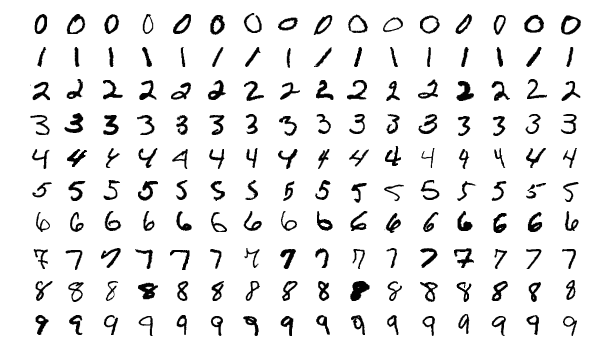

In [363]:
# mnist 샘플 이미지(분석에 사용되는 데이터셋 x)
Image("mnist.png")

해당 데이터셋은 MNIST 데이터 중 자주 쓰이는 숫자별로 샘플을 추출한 데이터셋이다. <u>MNIST(Modified National Institute of Standards and Technology database) 데이터셋이란, 손으로 작성한 숫자들로 이루어진 데이터들의 집합을 의미한다.</u> 다양한 기계학습 방법론을 적용하여 분석에 바로 활용할 수 있는 형태로 정제가 되어있으며, 기본적으로 28 × 28 해상도의 흑백 이미지로 구성되어있다. 각 행별로 label 열은 어떤 숫자인지를, pixel0~pixel783은 28 * 28 해상도의 이미지에 대한 픽셀 정보를 순서대로 나타내고 있다.  먼저, 숫자별 평균 이미지와 그에 대한 픽셀값을 통한 분석 성능을 알아보도록 한다.

### 모델 선정 배경
기계학습 방법론을 적용하여 숫자 인식의 원리를 탐구할 때, 이미지 정보가 담겨있는 데이터셋을 활용할 수 있는 방식으로 평균 이미지 방식, 지도 학습(KNN), 비지도 학습(K-means)를 선정하여 다방면으로 분석을 시도하였다. 이미지라는 데이터의 특성과 숫자 인식이라는 주제를 고려하였을 때, 데이터를 해석하여 분류를 진행하는 방향이 적합하다고 생각하였기 때문이다.

### 이미지 데이터 생성

In [283]:
# 데이터 전처리 - 숫자 이미지 생성
try:
    if not os.path.exists("dataset/img"):
        os.makedirs("dataset/img")
except OSError as e:
        print(e)
        
def get_num_img(row):
    path = "dataset/img"
    count = len(os.listdir(path))
    file = f"{str(count).zfill(5)}.jpg"
    
    size = 28
    
    # 비어있는(검은색만 존재하는) 이미지 만들기
    img = np.full((size, size), 0, dtype=np.uint8)
    
    pixel = row[1:]
    for i in range(size):
        row = pixel[size*i:size*(i+1)]
        img[i, :] = row[:]
        
    cv2.imwrite(f"{path}/{file}", img)
    
    return f"{path}/{file}"

df["path"] = df.apply(
    lambda x: get_num_img(x), axis=1
)

print(len(os.listdir("dataset/img")))
display(df)
df.to_csv("info.csv", index=False, encoding="utf-8-sig")

42000


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,path
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/00000.jpg
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/00001.jpg
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/00002.jpg
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/00003.jpg
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/00004.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/41995.jpg
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/41996.jpg
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/41997.jpg
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/41998.jpg


이미지의 대략적인 모습을 확인하고 이로 부터 얻어낸 평균 이미지를 직관적으로 파악하기 위해, 데이터셋의 픽셀 정보를 통해 각각의 이미지를 생성하는 과정을 진행하였다.

### 테스트 & 트레인 데이터 분리

In [285]:
df = pd.read_csv("info.csv", encoding="utf-8-sig")

In [287]:
X_train = df.sample(int(df.shape[0]*0.7), random_state=1234).sort_index()
X_test = df.drop(X_train.index)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [288]:
display(X_train.shape)
display(X_train)

(29399, 786)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,path
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/00000.jpg
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/00004.jpg
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/00005.jpg
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/00006.jpg
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/00008.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29394,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/41994.jpg
29395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/41995.jpg
29396,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/41996.jpg
29397,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/41997.jpg


In [289]:
display(X_test.shape)
display(X_test)

(12601, 786)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,path
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/00001.jpg
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/00002.jpg
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/00003.jpg
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/00007.jpg
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/00010.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12596,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/41988.jpg
12597,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/41991.jpg
12598,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/41992.jpg
12599,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dataset/digit/img/41993.jpg


In [290]:
display(X_train[["label", "path"]].groupby("label").count()[["path"]])

,path
label,
0,2922
1,3285
2,2912
3,3104
4,2855
5,2647
6,2877
7,3107
8,2797


### 이미지 데이터 변환(jpg to ndarray)

In [291]:
from PIL import Image

train_digits = []
for path in X_train["path"].to_list():
    img = Image.open(path) # 흑백 이미지를 uint8 타입으로 변환하기 위해 PIL로 load
    array_data = np.array(img, "uint8")
    train_digits.append(array_data)
    
train_digits = np.array(train_digits)
display(train_digits.shape)

(29399, 28, 28)

numpy 배열 또한 데이터셋의 픽셀 데이터에서 바로 생성하는게 아닌, 이미지 데이터를 읽어온 뒤 변환하는 과정을 거쳤다.

### 이미지 분류

In [292]:
train_num0 = train_digits[X_train["label"]==0]
display(train_num0.shape)

train_num1 = train_digits[X_train["label"]==1]
display(train_num1.shape)

train_num2 = train_digits[X_train["label"]==2]
display(train_num2.shape)

train_num3 = train_digits[X_train["label"]==3]
display(train_num3.shape)

train_num4 = train_digits[X_train["label"]==4]
display(train_num4.shape)

train_num5 = train_digits[X_train["label"]==5]
display(train_num5.shape)

train_num6 = train_digits[X_train["label"]==6]
display(train_num6.shape)

train_num7 = train_digits[X_train["label"]==7]
display(train_num7.shape)

train_num8 = train_digits[X_train["label"]==8]
display(train_num8.shape)

train_num9 = train_digits[X_train["label"]==9]
display(train_num9.shape)

(2922, 28, 28)

(3285, 28, 28)

(2912, 28, 28)

(3104, 28, 28)

(2855, 28, 28)

(2647, 28, 28)

(2877, 28, 28)

(3107, 28, 28)

(2797, 28, 28)

(2893, 28, 28)

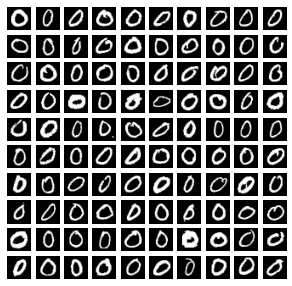

In [293]:
# 숫자 샘플 출력 - 0
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(train_num0[i*10 + j], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

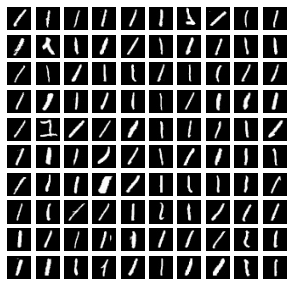

In [294]:
# 숫자 샘플 출력 - 1
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(train_num1[i*10 + j], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

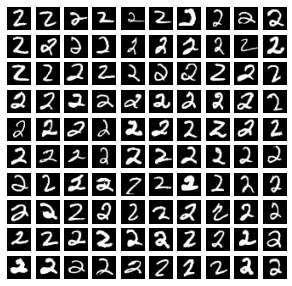

In [295]:
# 숫자 샘플 출력 - 2
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(train_num2[i*10 + j], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

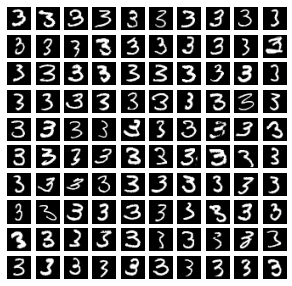

In [296]:
# 숫자 샘플 출력 - 3
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(train_num3[i*10 + j], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

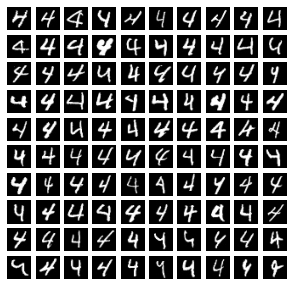

In [297]:
# 숫자 샘플 출력 - 4
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(train_num4[i*10 + j], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

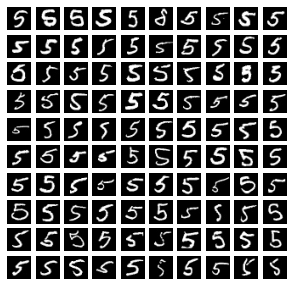

In [298]:
# 숫자 샘플 출력 - 5
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(train_num5[i*10 + j], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

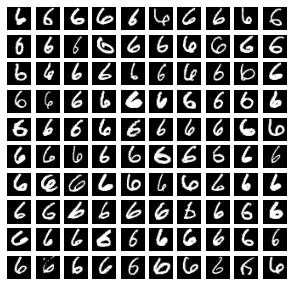

In [299]:
# 숫자 샘플 출력 - 6
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(train_num6[i*10 + j], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

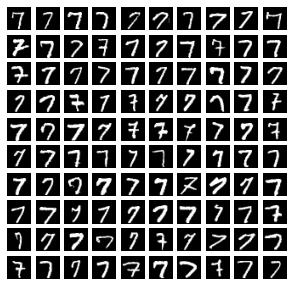

In [300]:
# 숫자 샘플 출력 - 7
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(train_num7[i*10 + j], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

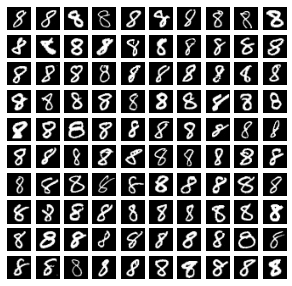

In [301]:
# 숫자 샘플 출력 - 8
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(train_num8[i*10 + j], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

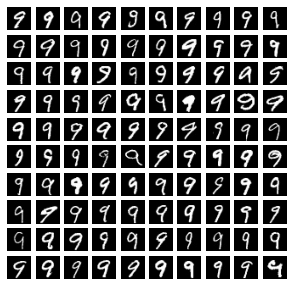

In [302]:
# 숫자 샘플 출력 - 9
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(train_num9[i*10 + j], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

생성한 이미지를 숫자별로 분류한 뒤 출력을 진행하였다.

### 차원 축소(3d->2d)

In [303]:
train_num0 = train_num0.reshape(-1, 28*28)
display(train_num0.shape)

train_num1 = train_num1.reshape(-1, 28*28)
display(train_num1.shape)

train_num2 = train_num2.reshape(-1, 28*28)
display(train_num2.shape)

train_num3 = train_num3.reshape(-1, 28*28)
display(train_num3.shape)

train_num4 = train_num4.reshape(-1, 28*28)
display(train_num4.shape)

train_num5 = train_num5.reshape(-1, 28*28)
display(train_num5.shape)

train_num6 = train_num6.reshape(-1, 28*28)
display(train_num6.shape)

train_num7 = train_num7.reshape(-1, 28*28)
display(train_num7.shape)

train_num8 = train_num8.reshape(-1, 28*28)
display(train_num8.shape)

train_num9 = train_num9.reshape(-1, 28*28)
display(train_num9.shape)

(2922, 784)

(3285, 784)

(2912, 784)

(3104, 784)

(2855, 784)

(2647, 784)

(2877, 784)

(3107, 784)

(2797, 784)

(2893, 784)

### 평균 픽셀 값을 통한 분류
각 그룹별 평균 픽셀 값으로 우선 분류

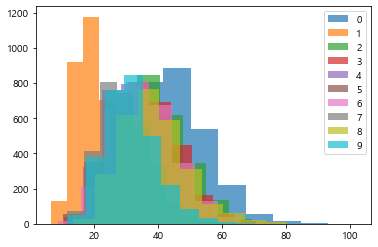

In [304]:
plt.hist(np.mean(train_num0, axis = 1), alpha = 0.7)
plt.hist(np.mean(train_num1, axis = 1), alpha = 0.7)
plt.hist(np.mean(train_num2, axis = 1), alpha = 0.7)
plt.hist(np.mean(train_num3, axis = 1), alpha = 0.7)
plt.hist(np.mean(train_num4, axis = 1), alpha = 0.7)
plt.hist(np.mean(train_num5, axis = 1), alpha = 0.7)
plt.hist(np.mean(train_num6, axis = 1), alpha = 0.7)
plt.hist(np.mean(train_num7, axis = 1), alpha = 0.7)
plt.hist(np.mean(train_num8, axis = 1), alpha = 0.7)
plt.hist(np.mean(train_num9, axis = 1), alpha = 0.7)

plt.legend(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
plt.show()

#### 픽셀 위치별 평균값을 통한 분류

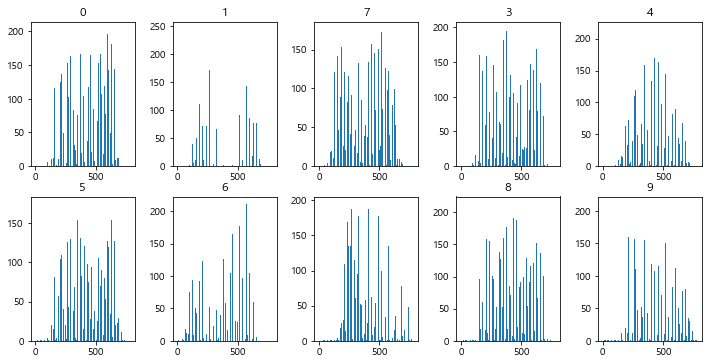

In [305]:
fig, axes = plt.subplots(2, 5, figsize = (10, 5))
fig.tight_layout()

axes[0, 0].bar(range(28*28), np.mean(train_num0, axis = 0))
axes[0, 0].set_title("0")

axes[0, 1].bar(range(28*28), np.mean(train_num1, axis = 0))
axes[0, 1].set_title("1")

axes[0, 2].bar(range(28*28), np.mean(train_num2, axis = 0))
axes[0, 2].set_title("2")

axes[0, 3].bar(range(28*28), np.mean(train_num3, axis = 0))
axes[0, 3].set_title("3")

axes[0, 4].bar(range(28*28), np.mean(train_num4, axis = 0))
axes[0, 4].set_title("4")

axes[1, 0].bar(range(28*28), np.mean(train_num5, axis = 0))
axes[1, 0].set_title("5")

axes[1, 1].bar(range(28*28), np.mean(train_num6, axis = 0))
axes[1, 1].set_title("6")

axes[1, 2].bar(range(28*28), np.mean(train_num7, axis = 0))
axes[0, 2].set_title("7")

axes[1, 3].bar(range(28*28), np.mean(train_num8, axis = 0))
axes[1, 3].set_title("8")

axes[1, 4].bar(range(28*28), np.mean(train_num9, axis = 0))
axes[1, 4].set_title("9")

plt.show()

#### 평균 이미지 생성
픽셀 위치별 평균값으로부터 평균 이미지 생성 후 출력

In [306]:
train_num0_mean = np.mean(train_num0, axis = 0).reshape(28, 28)
train_num1_mean = np.mean(train_num1, axis = 0).reshape(28, 28)
train_num2_mean = np.mean(train_num2, axis = 0).reshape(28, 28)
train_num3_mean = np.mean(train_num3, axis = 0).reshape(28, 28)
train_num4_mean = np.mean(train_num4, axis = 0).reshape(28, 28)
train_num5_mean = np.mean(train_num5, axis = 0).reshape(28, 28)
train_num6_mean = np.mean(train_num6, axis = 0).reshape(28, 28)
train_num7_mean = np.mean(train_num7, axis = 0).reshape(28, 28)
train_num8_mean = np.mean(train_num8, axis = 0).reshape(28, 28)
train_num9_mean = np.mean(train_num9, axis = 0).reshape(28, 28)

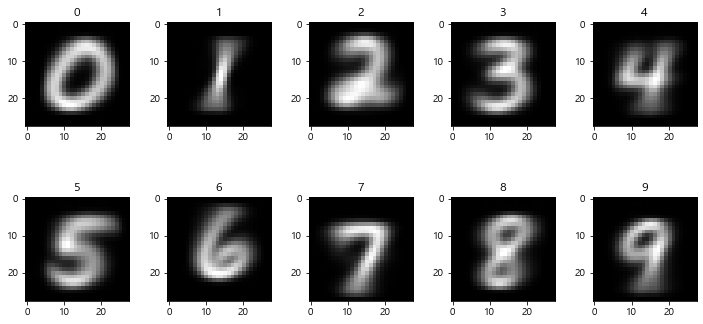

In [307]:
fig, axes = plt.subplots(2, 5, figsize = (10, 5))
fig.tight_layout()

axes[0, 0].imshow(train_num0_mean, cmap="gray")
axes[0, 0].set_title("0")

axes[0, 1].imshow(train_num1_mean, cmap="gray")
axes[0, 1].set_title("1")

axes[0, 2].imshow(train_num2_mean, cmap="gray")
axes[0, 2].set_title("2")

axes[0, 3].imshow(train_num3_mean, cmap="gray")
axes[0, 3].set_title("3")

axes[0, 4].imshow(train_num4_mean, cmap="gray")
axes[0, 4].set_title("4")

axes[1, 0].imshow(train_num5_mean, cmap="gray")
axes[1, 0].set_title("5")

axes[1, 1].imshow(train_num6_mean, cmap="gray")
axes[1, 1].set_title("6")

axes[1, 2].imshow(train_num7_mean, cmap="gray")
axes[1, 2].set_title("7")

axes[1, 3].imshow(train_num8_mean, cmap="gray")
axes[1, 3].set_title("8")

axes[1, 4].imshow(train_num9_mean, cmap="gray")
axes[1, 4].set_title("9")

plt.show()

숫자별 픽셀 데이터를 활용하여 평균 이미지를 작성하였다.

### 테스트 데이터로 분석 평가

In [308]:
test_digits = []

for path in X_test["path"].to_list():
    img = Image.open(path) # 흑백 이미지를 uint8 타입으로 변환하기 위해 PIL로 load
    array_data = np.array(img, "uint8")
    test_digits.append(array_data)
    
test_digits = np.array(test_digits)

test_num0 = test_digits[X_test["label"]==0].reshape(-1, 28*28)
test_num1 = test_digits[X_test["label"]==1].reshape(-1, 28*28)
test_num2 = test_digits[X_test["label"]==2].reshape(-1, 28*28)
test_num3 = test_digits[X_test["label"]==3].reshape(-1, 28*28)
test_num4 = test_digits[X_test["label"]==4].reshape(-1, 28*28)
test_num5 = test_digits[X_test["label"]==5].reshape(-1, 28*28)
test_num6 = test_digits[X_test["label"]==6].reshape(-1, 28*28)
test_num7 = test_digits[X_test["label"]==7].reshape(-1, 28*28)
test_num8 = test_digits[X_test["label"]==8].reshape(-1, 28*28)
test_num9 = test_digits[X_test["label"]==9].reshape(-1, 28*28)

test_num0_mean = np.mean(test_num0, axis = 0).reshape(28, 28)
test_num1_mean = np.mean(test_num1, axis = 0).reshape(28, 28)
test_num2_mean = np.mean(test_num2, axis = 0).reshape(28, 28)
test_num3_mean = np.mean(test_num3, axis = 0).reshape(28, 28)
test_num4_mean = np.mean(test_num4, axis = 0).reshape(28, 28)
test_num5_mean = np.mean(test_num5, axis = 0).reshape(28, 28)
test_num6_mean = np.mean(test_num6, axis = 0).reshape(28, 28)
test_num7_mean = np.mean(test_num7, axis = 0).reshape(28, 28)
test_num8_mean = np.mean(test_num8, axis = 0).reshape(28, 28)
test_num9_mean = np.mean(test_num9, axis = 0).reshape(28, 28)

display(test_digits.shape)

(12601, 28, 28)

In [309]:
import gc # 메모리 관리

In [310]:
# label 0
abs_diff_test_num0 = np.abs(test_digits - test_num0_mean)
abs_mean_test_num0 = np.mean(abs_diff_test_num0, axis = (1, 2))
test_num0_index = np.argsort(abs_mean_test_num0)

# 명시적 메모리 관리
del abs_mean_test_num0
del abs_diff_test_num0
gc.collect()

display(test_num0_index)

array([4133, 5797, 3104, ..., 7218, 4194, 1103], dtype=int64)

In [311]:
# 정확도 평가 변수 설정
# test_num_index에서 가리키는 숫자의 test 데이터 개수만큼 슬라이싱을 진행
# 위의 결과로 나온 범위에서 가리키는 숫자와 분류한 숫자가 일치하는 비율 계산
test_num0_count = len(X_test.loc[df["label"] == 0])
predict_num0_range = test_num0_index[:test_num0_count]
test_num0_range = np.array(X_test.loc[X_test["label"] == 0].index)
predict_num0_count = len(np.intersect1d(predict_num0_range, test_num0_range))

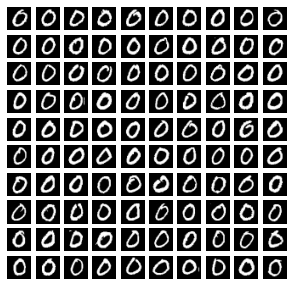

In [312]:
# 평균 픽셀값과 가장 차이가 적은 순으로 100개의 샘플 출략
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(test_digits[test_num0_index[:100][i*10 + j]], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

In [313]:
# num 1
abs_diff_test_num1 = np.abs(test_digits - test_num1_mean)
abs_mean_test_num1 = np.mean(abs_diff_test_num1, axis = (1, 2))
test_num1_index = np.argsort(abs_mean_test_num1)

# 명시적 메모리 관리
del abs_mean_test_num1
del abs_diff_test_num1
gc.collect()

display(test_num1_index)

array([9776, 9993, 1981, ...,  366,  739, 3099], dtype=int64)

In [314]:
# 정확도 평가 변수 설정
test_num1_count = len(X_test.loc[df["label"] == 1])
predict_num1_range = test_num1_index[:test_num1_count]
test_num1_range = np.array(X_test.loc[X_test["label"] == 1].index)
predict_num1_count = len(np.intersect1d(predict_num1_range, test_num1_range))

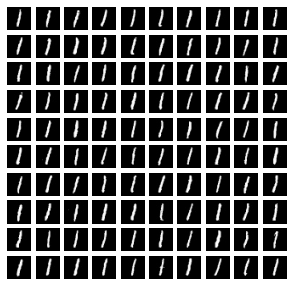

In [315]:
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(test_digits[test_num1_index[i*10 + j]], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

In [316]:
# num 2
abs_diff_test_num2 = np.abs(test_digits - test_num2_mean)
abs_mean_test_num2 = np.mean(abs_diff_test_num2, axis = (1, 2))
test_num2_index = np.argsort(abs_mean_test_num2)

# 명시적 메모리 관리
del abs_mean_test_num2
del abs_diff_test_num2
gc.collect()

display(test_num2_index)

array([8761, 7529, 2633, ..., 4194,  739, 5806], dtype=int64)

In [317]:
# 정확도 평가 변수 설정
test_num2_count = len(X_test.loc[df["label"] == 2])
predict_num2_range = test_num2_index[:test_num2_count]
test_num2_range = np.array(X_test.loc[X_test["label"] == 2].index)
predict_num2_count = len(np.intersect1d(predict_num2_range, test_num2_range))

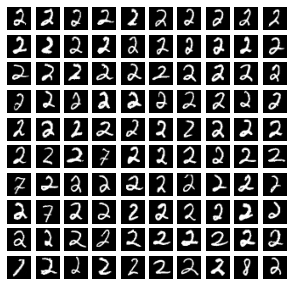

In [318]:
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(test_digits[test_num2_index[:100][i*10 + j]], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

In [319]:
# num 3
abs_diff_test_num3 = np.abs(test_digits - test_num3_mean)
abs_mean_test_num3 = np.mean(abs_diff_test_num3, axis = (1, 2))
test_num3_index = np.argsort(abs_mean_test_num3)

# 명시적 메모리 관리
del abs_mean_test_num3
del abs_diff_test_num3
gc.collect()

display(test_num3_index)

array([1369, 6215, 6070, ...,  739,  366, 3099], dtype=int64)

In [320]:
# 정확도 평가 변수 설정
test_num3_count = len(X_test.loc[df["label"] == 3])
predict_num3_range = test_num3_index[:test_num3_count]
test_num3_range = np.array(X_test.loc[X_test["label"] == 3].index)
predict_num3_count = len(np.intersect1d(predict_num3_range, test_num3_range))

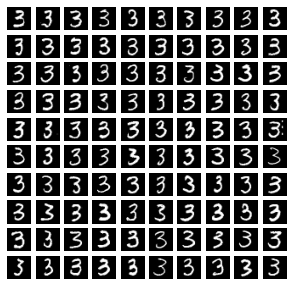

In [321]:
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(test_digits[test_num3_index[:100][i*10 + j]], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

In [322]:
# num 4
abs_diff_test_num4 = np.abs(test_digits - test_num4_mean)
abs_mean_test_num4 = np.mean(abs_diff_test_num4, axis = (1, 2))
test_num4_index = np.argsort(abs_mean_test_num4)

# 명시적 메모리 관리
del abs_mean_test_num4
del abs_diff_test_num4
gc.collect()

display(test_num4_index)

array([ 6099, 12334,  4068, ...,   366,  9796,    94], dtype=int64)

In [323]:
# 정확도 평가 변수 설정
test_num4_count = len(X_test.loc[df["label"] == 4])
predict_num4_range = test_num4_index[:test_num4_count]
test_num4_range = np.array(X_test.loc[X_test["label"] == 4].index)
predict_num4_count = len(np.intersect1d(predict_num4_range, test_num4_range))

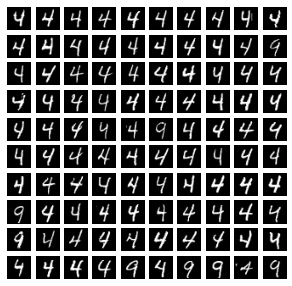

In [324]:
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(test_digits[test_num4_index[:100][i*10 + j]], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

In [325]:
# num 5
abs_diff_test_num5 = np.abs(test_digits - test_num5_mean)
abs_mean_test_num5 = np.mean(abs_diff_test_num5, axis = (1, 2))
test_num5_index = np.argsort(abs_mean_test_num5)

# 명시적 메모리 관리
del abs_mean_test_num5
del abs_diff_test_num5
gc.collect()

display(test_num5_index)

array([ 2088, 12043,  8372, ...,   366,  3099,  9896], dtype=int64)

In [326]:
# 정확도 평가 변수 설정
test_num5_count = len(X_test.loc[df["label"] == 5])
predict_num5_range = test_num5_index[:test_num5_count]
test_num5_range = np.array(X_test.loc[X_test["label"] == 5].index)
predict_num5_count = len(np.intersect1d(predict_num5_range, test_num5_range))

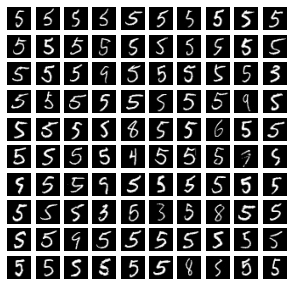

In [327]:
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(test_digits[test_num5_index[:100][i*10 + j]], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

In [328]:
# num 6
abs_diff_test_num6 = np.abs(test_digits - test_num6_mean)
abs_mean_test_num6 = np.mean(abs_diff_test_num6, axis = (1, 2))
test_num6_index = np.argsort(abs_mean_test_num6)

# 명시적 메모리 관리
del abs_mean_test_num6
del abs_diff_test_num6
gc.collect()

display(test_num6_index)

array([7478, 2068, 9722, ..., 6187, 4077, 2714], dtype=int64)

In [329]:
# 정확도 평가 변수 설정
test_num6_count = len(X_test.loc[df["label"] == 6])
predict_num6_range = test_num6_index[:test_num6_count]
test_num6_range = np.array(X_test.loc[X_test["label"] == 6].index)
predict_num6_count = len(np.intersect1d(predict_num6_range, test_num6_range))

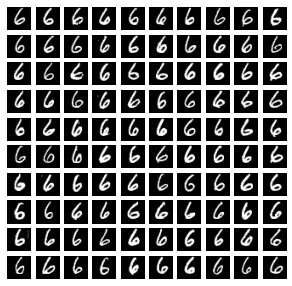

In [330]:
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(test_digits[test_num6_index[:100][i*10 + j]], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

In [331]:
# num 7
abs_diff_test_num7 = np.abs(test_digits - test_num7_mean)
abs_mean_test_num7 = np.mean(abs_diff_test_num7, axis = (1, 2))
test_num7_index = np.argsort(abs_mean_test_num7)

# 명시적 메모리 관리
del abs_mean_test_num7
del abs_diff_test_num7
gc.collect()

display(test_num7_index)

array([3441, 2669, 9580, ..., 3099,  739, 6961], dtype=int64)

In [332]:
# 정확도 평가 변수 설정
test_num7_count = len(X_test.loc[df["label"] == 7])
predict_num7_range = test_num7_index[:test_num7_count]
test_num7_range = np.array(X_test.loc[X_test["label"] == 7].index)
predict_num7_count = len(np.intersect1d(predict_num7_range, test_num7_range))

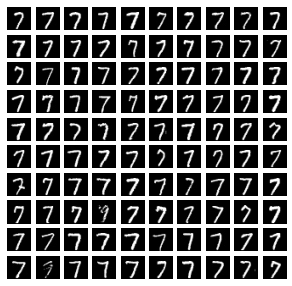

In [333]:
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(test_digits[test_num7_index[:100][i*10 + j]], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

In [334]:
# num 8
abs_diff_test_num8 = np.abs(test_digits - test_num8_mean)
abs_mean_test_num8 = np.mean(abs_diff_test_num8, axis = (1, 2))
test_num8_index = np.argsort(abs_mean_test_num8)

# 명시적 메모리 관리
del abs_mean_test_num8
del abs_diff_test_num8
gc.collect()

display(test_num8_index)

array([ 1642, 11427,  2273, ...,   366, 10833,  3099], dtype=int64)

In [335]:
# 정확도 평가 변수 설정
test_num8_count = len(X_test.loc[df["label"] == 8])
predict_num8_range = test_num8_index[:test_num8_count]
test_num8_range = np.array(X_test.loc[X_test["label"] == 8].index)
predict_num8_count = len(np.intersect1d(predict_num8_range, test_num8_range))

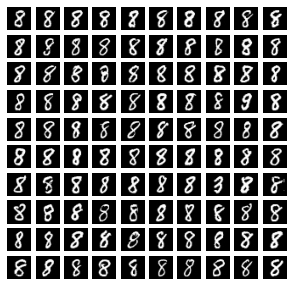

In [336]:
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(test_digits[test_num8_index[:100][i*10 + j]], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

In [337]:
# num 9
abs_diff_test_num9 = np.abs(test_digits - test_num9_mean)
abs_mean_test_num9 = np.mean(abs_diff_test_num9, axis = (1, 2))
test_num9_index = np.argsort(abs_mean_test_num9)

# 명시적 메모리 관리
del abs_mean_test_num9
del abs_diff_test_num9
gc.collect()

display(test_num9_index)

array([11670,  8356,  8700, ...,    94,  6090,  2714], dtype=int64)

In [338]:
# 정확도 평가 변수 설정
test_num9_count = len(X_test.loc[df["label"] == 9])
predict_num9_range = test_num9_index[:test_num9_count]
test_num9_range = np.array(X_test.loc[X_test["label"] == 9].index)
predict_num9_count = len(np.intersect1d(predict_num9_range, test_num9_range))

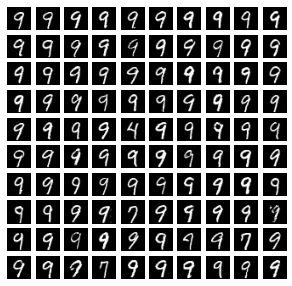

In [339]:
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(test_digits[test_num9_index[:100][i*10 + j]], cmap="gray")
        axes[i,j].axis("off")
        
plt.show()

### 평균 이미지 방식 성능 평가 지표

In [340]:
mean_img = {
    # 평균 이미지로 분류한 숫자 개수
    "predict" : {
        0: predict_num0_count,
        1: predict_num1_count,
        2: predict_num2_count,
        3: predict_num3_count,
        4: predict_num4_count,
        5: predict_num5_count,
        6: predict_num6_count,
        7: predict_num7_count,
        8: predict_num8_count,
        9: predict_num9_count,
    },
    # 테스트 이미지의 실제 숫자 개수
    "test" : {
        0: test_num0_count,
        1: test_num1_count,
        2: test_num2_count,
        3: test_num3_count,
        4: test_num4_count,
        5: test_num5_count,
        6: test_num6_count,
        7: test_num7_count,
        8: test_num8_count,
        9: test_num9_count,
    }
}

mean_img_result = pd.DataFrame([], columns=mean_img.keys(), index=range(10))

for i in mean_img_result.index:
    mean_img_result.loc[i] = [mean_img[column][i] for column in mean_img_result.columns]

mean_img_result.loc["total"] = [mean_img_result["predict"].sum(), mean_img_result["test"].sum()]
mean_img_result.loc[:, "accuracy"] = (mean_img_result.loc[:, "predict"] / mean_img_result.loc[:, "test"]) * 100
    
display(mean_img_result)

,predict,test,accuracy
0,962,1234,77.957861
1,1217,1418,85.825106
2,536,1292,41.486068
3,686,1273,53.888452
4,626,1219,51.353568
5,380,1158,32.815199
6,901,1272,70.833333
7,791,1298,60.939908
8,632,1203,52.535328
9,707,1234,57.293355


숫자별로 평균 이미지와 위치별 픽셀값의 차이가 적은 순으로 정렬한 경우에는 평균에 가까울 수록(출력 순서가 빠른 순서일수록) 어느정도 정확한 분류가 이루어진 경향을 파악할 수 있었지만, 전체 범위에서 봤을 때 숫자별로 분류 성능의 격차가 큰 것을 알 수 있다. 단순한 위치별 픽셀값을 기반으로 수행한 분류는 유사한 형태의 이미지로 인식한 경우가 많았음을 알 수 있다.(9와 4, 8과 3 등) 

### 평균 이미지 방식 응용 - 가상의 이미지 인식 패키지 작성
평균 이미지를 통한 숫자 이미지 분류 방식에서 필체와 굵기별 분류 성능을 한 차례 더 파악해보기 위해, 가상의 숫자 인식 패키지를 제작을 하여 테스트를 진행하였다.

In [341]:
# 데이터의 분리 없이 전체 데이터를 통해 평균 이미지 제작
digits = []
for path in df["path"].to_list():
    img = Image.open(path) # 흑백 이미지를 uint8 타입으로 변환하기 위해 PIL로 load
    array_data = np.array(img, "uint8")
    digits.append(array_data)
    
digits = np.array(digits)

num0 = digits[df["label"]==0].reshape(-1, 28*28)
num1 = digits[df["label"]==1].reshape(-1, 28*28)
num2 = digits[df["label"]==2].reshape(-1, 28*28)
num3 = digits[df["label"]==3].reshape(-1, 28*28)
num4 = digits[df["label"]==4].reshape(-1, 28*28)
num5 = digits[df["label"]==5].reshape(-1, 28*28)
num6 = digits[df["label"]==6].reshape(-1, 28*28)
num7 = digits[df["label"]==7].reshape(-1, 28*28)
num8 = digits[df["label"]==8].reshape(-1, 28*28)
num9 = digits[df["label"]==9].reshape(-1, 28*28)

In [342]:
num0_mean = np.mean(num0, axis = 0).reshape(28, 28)
num1_mean = np.mean(num1, axis = 0).reshape(28, 28)
num2_mean = np.mean(num2, axis = 0).reshape(28, 28)
num3_mean = np.mean(num3, axis = 0).reshape(28, 28)
num4_mean = np.mean(num4, axis = 0).reshape(28, 28)
num5_mean = np.mean(num5, axis = 0).reshape(28, 28)
num6_mean = np.mean(num6, axis = 0).reshape(28, 28)
num7_mean = np.mean(num7, axis = 0).reshape(28, 28)
num8_mean = np.mean(num8, axis = 0).reshape(28, 28)
num9_mean = np.mean(num9, axis = 0).reshape(28, 28)

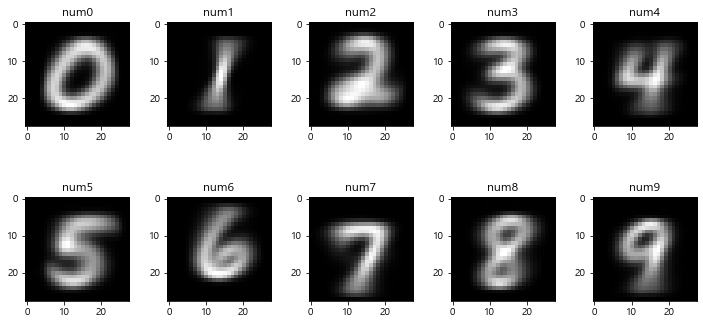

In [343]:
fig, axes = plt.subplots(2, 5, figsize = (10, 5))
fig.tight_layout()

axes[0, 0].imshow(num0_mean, cmap="gray")
axes[0, 0].set_title("num0")

axes[0, 1].imshow(num1_mean, cmap="gray")
axes[0, 1].set_title("num1")

axes[0, 2].imshow(num2_mean, cmap="gray")
axes[0, 2].set_title("num2")

axes[0, 3].imshow(num3_mean, cmap="gray")
axes[0, 3].set_title("num3")

axes[0, 4].imshow(num4_mean, cmap="gray")
axes[0, 4].set_title("num4")

axes[1, 0].imshow(num5_mean, cmap="gray")
axes[1, 0].set_title("num5")

axes[1, 1].imshow(num6_mean, cmap="gray")
axes[1, 1].set_title("num6")

axes[1, 2].imshow(num7_mean, cmap="gray")
axes[1, 2].set_title("num7")

axes[1, 3].imshow(num8_mean, cmap="gray")
axes[1, 3].set_title("num8")

axes[1, 4].imshow(num9_mean, cmap="gray")
axes[1, 4].set_title("num9")

plt.show()

In [344]:
class Recognizer:
    """ 개요 및 주의사항
    본 예제에서는 앞서 실행한 숫자별 평균 픽셀 데이터(모델)을 활용하지만,
    실제 패키지 형태로 사용하기 위해서는 Recognizer 클래스 내부에서 
    평균 픽셀값을 계산하여 학습시키는 과정이 필요함
    또한, 예제로 작성하는 패키지이므로 테스트 이미지는 아래와 같은 조건이 요구됨
    1. 흰 배경 위에 적절한 굵기의 펜으로 적힌 숫자
    2. 사진 외곽의 여백이 없어야 함
    3. 숫자로만 이루어져야함 (숫자 이외의 텍스트는 항상 잘못된 인식 결과를 만듬)
    """
    def __init__(self):
        self.means = {
            0: num0_mean, 1: num1_mean, 2: num2_mean, 3: num3_mean, 4: num4_mean,
            5: num5_mean, 6: num6_mean, 7: num7_mean, 8: num8_mean, 9: num9_mean,
        }
    
    """ 이미지에서 인식한 숫자 영역을 숫자별로 학습된 모델을 통해 텍스트로 변환하는 메서드 """
    def run(self, img):
        # img = cv2.imread(path)
        imgs = self.get_digit_imgs(img)
        result_list = [] 
        
        # 숫자별로 학습된 평균 픽셀 데이터로 가장 적절한 결과값 선별
        count = 0
        for i, img in enumerate(imgs):
            abs_diff_mean_list = []
            diff_mean_list = []
            for index, mean in self.means.items(): # 삽입 순서 보존 -> 0, 1, 2, ... 순
                """ 
                1. 모델의 이미지와 분석할 숫자 이미지는 모두 '숫자 부분이 흰색(255이거나 255에 가까움), 여백 부분이 검은색(0)'인 행렬로 표현된다.
                   (분석 이미지는 이진화 처리 되어있기 때문에 모든 값이 0 혹은 255로 정해져있으나, 학습된 이미지는 평균값의 형태이므로 0~255의 범위를 갖는다.)
                2. 이러한 형태의 행렬의 평균 값이 높을수록 흰색(및 밝은 색)이 많이 포함된 이미지이고, 0에 가까울수록 검은색이 많이 포함된 이미지라 생각할 수 있다.
                3. 각 숫자별 이미지를 숫자별 평균 이미지로 빼기 연산을 진행한 후 절대값을 씌운 행렬의 평균 값을 계산한다.
                             (ㄴ변수 img)    (ㄴmeans 변수 (self.means의 value 요소들))
                4. 3번 항목의 연산을 통해 10개의 평균 값이 나오고, 2번의 가정에 의해 10개의 값 중 최소값이 가장 어두운(혹은 검은색에 가까운) 이미지라 생각할 수 있다.
                5. 즉, 이미지의 위치별 픽셀이 많이 겹칠수록 흰색의 픽셀이 검은색에 더 많이 가까워졌다는 뜻이므로,
                   최소값의 인덱스가 곧 분석 이미지와 가장 유사한 형태의 평균 이미지라고 생각할 수 있다.                                                                                        
                """
                # 1안 : 평균값을 통한 검출
                abs_diff = np.abs(img - mean)  
                # cv2.imwrite(f"dataset/digit/debug/{count}.jpg", abs_diff)
                # count += 1
                abs_diff_mean = np.mean(abs_diff) # axis 구분 없이 전체 평균값을 구하는게 적절할까?
                abs_diff_mean_list.append(abs_diff_mean)
                
                # 2안 : 음수값을 0으로 처리(0보다 낮은 값은 없는 색, 즉 검은색)
                # diff = img - mean
                # adjust_diff = np.where(diff < 0, 0, diff)
                # diff_mean = np.mean(adjust_diff)
                # diff_mean_list.append(diff_mean)
            
            # 각 숫자별로 abs_diff_mean_list의 최소값 인덱스 계산 (인덱스가 곧 가장 유사도가 높은 인식 결과라는 판단)
            result = np.argmin(abs_diff_mean_list)
            result_list.append(result)
            
            # result = np.argmin(diff_mean_list)
            # result_list.append(result)
            
    
        return result_list
    
    """ 이미지에서 인식한 숫자 영역을 숫자별 이미지 형태로 출력하는 메서드 (이미지별 픽셀 데이터 반환) """
    def show_normal_digit(self, img):
        # img = cv2.imread(path)
        imgs = self.get_digit_imgs(img)
    
        if len(imgs) == 1:
            plt.figsize=(10,10)
            plt.imshow(imgs[0], cmap="gray")
        else:
            fig, axes = plt.subplots(1, len(imgs), figsize=(15,15))
            for i, img in enumerate(imgs):
                axes[i].imshow(img, cmap="gray")
                axes[i].axis("off")
                
                
        # 이미지별 픽셀 정보 반환
        pixel_data = pd.DataFrame([], columns=["pixcel"+str(i) for i in range(28*28)], index=range(len(imgs)))
        
        for i, img in enumerate(imgs):
            pixel_data.loc[i] = img.reshape(-1)

        return pixel_data
    
    """ 전체 이미지에서 추출된 숫자의 세로 영역 이미지에서 마저 가로 영역까지 검출하는 메서드 """
    def get_digit_imgs(self, img):        
        vertical_img_list = self.get_vertical_img(img)
        img_nums = len(vertical_img_list)
        if img_nums == 0:
            return []
        else:
            digit_imgs = []
            # 좌우를 crop한 이미지를 상->하 순회
            for vertical_img in vertical_img_list:
                # 정확한 범위를 검출하기 위한 바이너리 이미지 생성
                binary_img = cv2.threshold(vertical_img, 100, 255, cv2.THRESH_BINARY)[1] 
                height, width = vertical_img.shape
                height_range = []
                is_range = False
                for row in range(height):
                    if binary_img[row, :].all(): # 하나의 행이 모두 빈 경우
                        if is_range:
                            is_range = not is_range
                            height_range.append(row)
                    else:                 # 글자 영역 시작 감지
                        if not is_range:
                            is_range = not is_range
                            height_range.append(row)
                else: # 상->하 순회가 끝난 경우
                    y1y2_list = [height_range[i*2:(i+1)*2] for i in range((len(height_range)+1)//2)] 
                    for y1y2 in y1y2_list:
                        if len(y1y2) != 2:
                            continue
                        y1, y2 = y1y2
                        digit_imgs.append(vertical_img[y1:y2:, :])
                    
            return self.normalize_img(digit_imgs)
    
    """ 전체 이미지에서 숫자의 세로 영역을 검출하는 메서드  """
    def get_vertical_img(self, img):
        # 그레이 스케일
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # 정확한 범위를 검출하기 위한 바이너리 이미지 생성
        binary_img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)[1]       
        
        height, width = img.shape
        width_range = []
        vertical_img_list = []
        is_range = False
        
        # 이미지의 좌->우 순회
        for col in range(width):
            if binary_img[:, col].all(): # 글자 영역 끝 감지
                # print("0,", end=" ")
                if is_range:
                    is_range = not is_range
                    width_range.append(col-1)
            else: # 글자 영역 시작 감지
                # print("1,", end=" ")
                if not is_range:
                    is_range = not is_range
                    width_range.append(col+1)
        else: # 좌->우 순회가 끝난 경우
            x1x2_list = [width_range[i*2:(i+1)*2] for i in range((len(width_range)+1)//2)] 
            for x1x2 in x1x2_list:
                if len(x1x2) != 2: # 픽셀이 서로 한 쌍을 이루지 않는 경우(불필요한 값으로 간주)
                    continue
                x1, x2 = x1x2
                vertical_img_list.append(img[:, x1:x2])
                
        return vertical_img_list
    
    """ 검출된 숫자 이미지를 학습된 이미지의 형태와 크기로 조정하는 함수 """
    def normalize_img(self, digit_imgs):
        normalized_digit_imgs = []
        for digit_img in digit_imgs:
            height, width = digit_img.shape
            # 이미지의 비율을 유지하여 정사각형 형태로 만들기
            if height > width:
                spaces = (height-width) // 2
                # 비어있는(흰색만만 존재하는) 이미지 만들기
                square = np.full((height, height), 255, dtype=np.uint8)
                square[:, spaces:width+spaces] = digit_img[:, :]
            elif height < width:
                spaces = (width-height) // 2
                # 비어있는(흰색만만 존재하는) 이미지 만들기
                square = np.full((width, width), 255, dtype=np.uint8)
                square[spaces:height+spaces, :] = digit_img[:, :]

            # 이미지 크기 조정
            square = cv2.resize(square, (20, 20), interpolation=cv2.INTER_LINEAR)  

            # 배경 삭제 효과를 위한 밝기 & 대비 조정
            brightness = -40
            contrast = 120
            square = square * (contrast/127+1) - contrast + brightness
            square = np.clip(square, 0, 255)
            
            # 배경 삭제 효과를 위한 감마 조정
            gamma = 4.0
            square = square.astype(np.float)
            square = ((square / 255) ** (1 / gamma)) * 255
            
            # 이미지에 여백 추가
            background = np.full((28, 28), 255, dtype=np.uint8)
            background[4:24, 4:24] = square[:, :]
            
            # 이미지 반전
            background = 255 - background

            normalized_digit_imgs.append(background)

        return normalized_digit_imgs

### 테스트 이미지 - 1

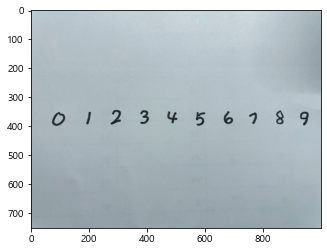

In [346]:
test_img1 = cv2.imread("test1.jpg")

plt.imshow(test_img1)

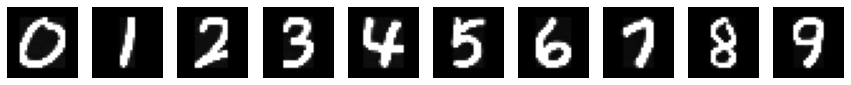

In [347]:
recognizer = Recognizer()

test_img1_data = recognizer.show_normal_digit(test_img1)

In [348]:
display(test_img1_data.shape)

(10, 784)

In [129]:
result1 = recognizer.run(test_img1)
for num in result1:
    print(num, end=" ")

0 1 2 3 4 5 6 7 8 9 

### 테스트 이미지 - 2

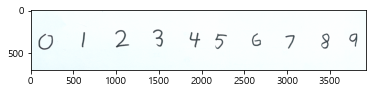

In [350]:
test_img2 = cv2.imread("test2.jpg")

plt.imshow(test_img2)

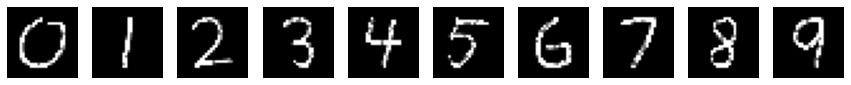

In [351]:
recognizer = Recognizer()

test_img2_data = recognizer.show_normal_digit(test_img2)

In [352]:
display(test_img2_data.shape)

(10, 784)

In [353]:
result2 = recognizer.run(test_img2)
for num in result2:
    print(num, end=" ")

1 1 1 1 1 1 1 1 1 4 

### 테스트 이미지 - 3

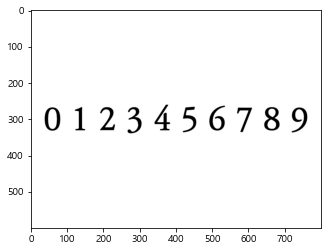

In [354]:
test_img3 = cv2.imread("test3.jpg")

plt.imshow(test_img3)

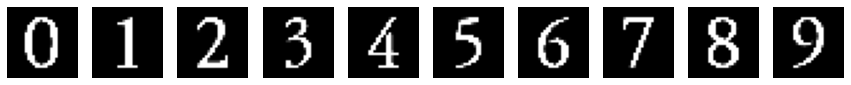

In [355]:
recognizer = Recognizer()

test_img3_data = recognizer.show_normal_digit(test_img3)

In [356]:
display(test_img3_data.shape)

(10, 784)

In [357]:
result3 = recognizer.run(test_img3)
for num in result3:
    print(num, end=" ")

4 1 1 1 1 1 6 1 3 7 

테스트 결과를 봤을 때, 평균 이미지와 유사한 필체 및 펜 굵기로 작성된 숫자의 경우는 준수한 성능을 보여줬지만, 그렇지 않은 경우는 생각보다 분류를 잘하지 못하는 모습을 보여줬다. 이는 <u>(1)숫자별로 평균 이미지를 제작하는데 사용된 표본의 절대적인 개수가 적었기 때문에</u> 여러가지 필체와 펜의 굵기에 영향을 많이 받았고, <u>(2) 이미지의 해상도가 28×28로 매우 작았기 때문에</u> 테스트한 이미지가 숫자별로 28×28의 크기로 작아지는 과정에서 적지 않은 픽셀 데이터의 손실이 일어난 것에서 기인한 결과로 추정할 수 있다. 그렇다면, 기계학습 방법론을 적용하여 분석을 진행해본 뒤 그 결과와 비교분석 해보자.

---
# 2. 기계학습 방법론 적용 : 지도 학습(KNN)

In [71]:
df = pd.read_csv("train.csv")
display(df)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
X = df.drop(["label"], axis=1)
Y = df[["label"]]

In [73]:
X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
Y.head()

,label
0,1
1,0
2,1
3,4
4,0


In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, train_size=0.7, test_size=0.3, random_state=1234)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(29399, 784) (12600, 784) (29399, 1) (12600, 1)


In [76]:
import sklearn.preprocessing as preprocessing
from sklearn.neighbors import KNeighborsRegressor

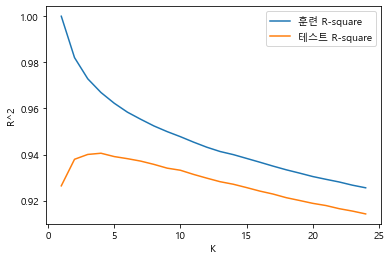

In [77]:
training_rsquare = []
test_rsquare = []
# 여러 k값에 대한 모델 생성 n_neighbors 를 적용
k_settings = range(1, 25)

for k in k_settings:
    # 모델 생성
    corolla_knn = KNeighborsRegressor(n_neighbors=k)
    corolla_knn.fit(X_train, Y_train)
    # 훈련 세트 정확도 저장
    training_rsquare.append(corolla_knn.score(X_train, Y_train))
    # 일반화 정확도 저장
    test_rsquare.append(corolla_knn.score(X_test, Y_test))

# K의 변황량에 따른 예측정확도 성능 비교
plt.plot(k_settings, training_rsquare, label="훈련 R-square")
plt.plot(k_settings, test_rsquare, label="테스트 R-square")
plt.ylabel("R^2")
plt.xlabel("K")
plt.legend()

In [78]:
from itertools import compress

# 최적의 K 판단
best_k_temp = test_rsquare == max(test_rsquare)
best_k = list(compress(k_settings, best_k_temp))[0]
print('최적의 K값:', best_k)

최적의 K값: 4


In [79]:
# 최적의 K값에서 테스트 데이터의 Y예측값
best_corolla_knn = KNeighborsRegressor(n_neighbors=best_k)
best_corolla_knn.fit(X_train, Y_train)
Y_predict = best_corolla_knn.predict(X_test)
print(Y_predict)

[[1.]
 [5.]
 [8.]
 ...
 [1.]
 [0.]
 [7.]]


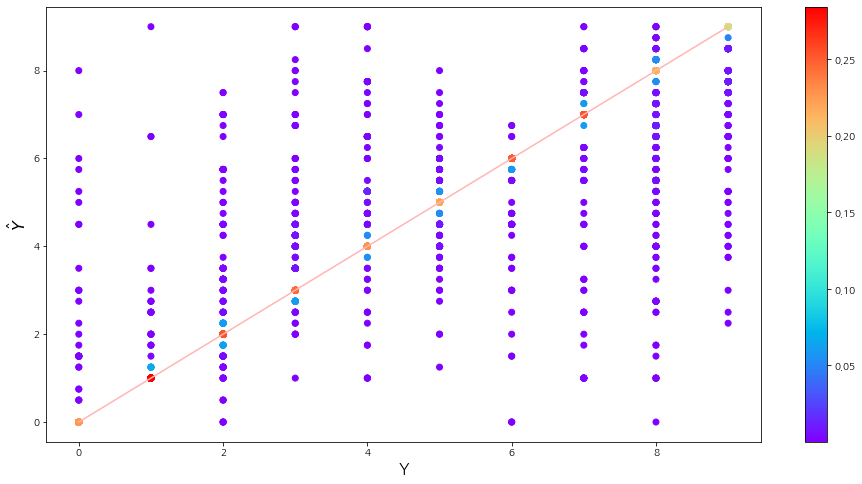

In [12]:
from scipy.stats import gaussian_kde

# 밀도 계산
vstack = np.vstack([Y_test["label"].values.tolist(), Y_predict.reshape(-1)])
density = gaussian_kde(vstack)(vstack)

plt.figure(figsize = (16, 8))
plt.scatter(Y_test, Y_predict, c=density, cmap = plt.cm.rainbow)
plt.xlabel('Y', size = 16)
plt.ylabel('$\hat{Y}$', size = 16)
plt.plot([0, 9], [0, 9], color="#FFB5B5")
plt.colorbar()
plt.show()

산점도를 값의 밀도를 반영한 색상 범위로 표현하였다. y=x 그래프를 그렸을 때, 해당 직선과 겹치는 점이 실제 Y값과 예측한 Y값이 일치하는 부분이며 이 부분의 밀도가 주변에 비해 높은 것을 확인할 수 있다. 하지만, 현재의 예측한 Y값은 실수가 섞여있는데, 숫자 인식이라는 주제에서는 무조건 정수의 값을 다뤄야 적절하므로 이를 정수로 변환한 뒤의 성능 지표를 짚어보는게 유의미하다고 생각하였다.

### 정수 변환

In [30]:
Y_predict_adjust = np.floor(Y_predict)

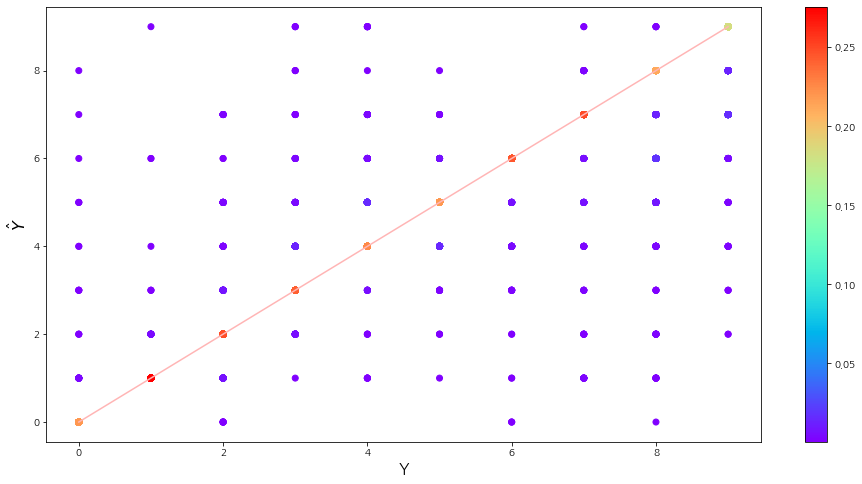

In [14]:
from scipy.stats import gaussian_kde

# 밀도 계산
vstack = np.vstack([Y_test["label"].values.tolist(), Y_predict_adjust.reshape(-1)])
density = gaussian_kde(vstack)(vstack)

plt.figure(figsize = (16, 8))
plt.scatter(Y_test, Y_predict_adjust, c=density, cmap = plt.cm.rainbow)
plt.xlabel('Y', size = 16)
plt.ylabel('$\hat{Y}$', size = 16)
plt.plot([0, 9], [0, 9], color="#FFB5B5")
plt.colorbar()
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 

# MSE(mean squared error), R-squared (모형 성능 비교)
mae = mean_absolute_error(Y_test, Y_predict_adjust)
mse = mean_squared_error(Y_test, Y_predict_adjust)
rmse = np.sqrt(mse)
r_square = r2_score(Y_test, Y_predict_adjust)

print("MAE from KNN Regression : {0:.3f}".format(mae))
print("MSE from KNN Regression : {0:.3f}".format(mse))
print("RMSE from KNN Regression : {0:.3f}".format(rmse))
print("R-square from KNN Regression : {0:.3f}".format(r_square))

MAE from KNN Regression : 0.185
MSE from KNN Regression : 0.540
RMSE from KNN Regression : 0.735
R-square from KNN Regression : 0.935


실수 보정 전의 그래프에서는 실제 Y값과 예측한 Y값에 가까울 수록 밀도가 높아지는 현상이 존재했었는데, 보정 이후에는 이러한 값들이 반올림처리되면서 한 곳으로 모인 것을 확인할 수 있다. 밀도 표현 산점도와 오차행렬 수치 외에 평균 이미지 방식 유사한 형태로 성능 평가 지표를 추가해보고자 한다.

### 성능 평가 지표(KNN)

In [31]:
# 1차원 & 정수값을 갖는 행렬로 재변환
Y_predict_adjust = Y_predict_adjust.reshape(-1).astype(int)

display(Y_predict_adjust)
display(Y_predict_adjust.shape)

array([1, 5, 8, ..., 1, 0, 7])

(12600,)

In [29]:
# 1차원 배열로 형태의 테스트 Y값 배열 선언
Y_test_adjust = np.array(Y_test["label"].tolist())

display(Y_test_adjust)
display(Y_test_adjust.shape)

array([1, 5, 8, ..., 1, 0, 7])

(12600,)

In [53]:
knn = {
    # 평균 이미지로 분류한 숫자 개수
    "predict" : {
        0: (Y_predict_adjust == Y_test_adjust)[Y_test_adjust == 0].sum(),
        1: (Y_predict_adjust == Y_test_adjust)[Y_test_adjust == 1].sum(),
        2: (Y_predict_adjust == Y_test_adjust)[Y_test_adjust == 2].sum(),
        3: (Y_predict_adjust == Y_test_adjust)[Y_test_adjust == 3].sum(),
        4: (Y_predict_adjust == Y_test_adjust)[Y_test_adjust == 4].sum(),
        5: (Y_predict_adjust == Y_test_adjust)[Y_test_adjust == 5].sum(),
        6: (Y_predict_adjust == Y_test_adjust)[Y_test_adjust == 6].sum(),
        7: (Y_predict_adjust == Y_test_adjust)[Y_test_adjust == 7].sum(),
        8: (Y_predict_adjust == Y_test_adjust)[Y_test_adjust == 8].sum(),
        9: (Y_predict_adjust == Y_test_adjust)[Y_test_adjust == 9].sum(),
    },
    # 테스트 이미지의 실제 숫자 개수
    "test" : {
        0: (Y_test_adjust == 0).sum(),
        1: (Y_test_adjust == 1).sum(),
        2: (Y_test_adjust == 2).sum(),
        3: (Y_test_adjust == 3).sum(),
        4: (Y_test_adjust == 4).sum(),
        5: (Y_test_adjust == 5).sum(),
        6: (Y_test_adjust == 6).sum(),
        7: (Y_test_adjust == 7).sum(),
        8: (Y_test_adjust == 8).sum(),
        9: (Y_test_adjust == 9).sum(),
    }
}

knn_result = pd.DataFrame([], columns=knn.keys(), index=range(10))

for i in knn_result.index:
    knn_result.loc[i] = [knn[column][i] for column in knn_result.columns]

knn_result.loc["total"] = [knn_result["predict"].sum(), knn_result["test"].sum()]
knn_result.loc[:, "accuracy"] = (knn_result.loc[:, "predict"] / knn_result.loc[:, "test"]) * 100
    
display(knn_result)

,predict,test,accuracy
0,1212,1240,97.741935
1,1383,1404,98.504274
2,1138,1253,90.822027
3,1175,1305,90.038314
4,1071,1222,87.643208
5,1007,1139,88.410887
6,1186,1241,95.56809
7,1246,1320,94.393939
8,949,1219,77.850697
9,1059,1257,84.24821


평균 이미지 방식보다는 전반적으로 높은 분류 성능을 보여주었다. 비지도학습으로 넘어가기 전, KNN으로 학습한 모델이 위의 테스트 이미지 1, 2, 3을 어떻게 분류하는지 짚어보고자 한다.

### 테스트 이미지 평가(KNN)

In [86]:
test_img1_predict = best_corolla_knn.predict(test_img1_data)
test_img1_predict_adjust = np.floor(test_img1_predict).reshape(-1).astype(int)

print(test_img1_predict_adjust)

[0 1 2 3 4 5 6 7 8 7]


In [87]:
test_img2_predict = best_corolla_knn.predict(test_img2_data)
test_img2_predict_adjust = np.floor(test_img2_predict).reshape(-1).astype(int)

print(test_img2_predict_adjust)

[0 1 2 3 4 3 4 2 7 4]


In [88]:
test_img3_predict = best_corolla_knn.predict(test_img3_data)
test_img3_predict_adjust = np.floor(test_img3_predict).reshape(-1).astype(int)

print(test_img3_predict_adjust)

[0 1 2 3 1 4 2 1 3 3]


전체적으로 봤을 때 숫자를 잘 분류한 개수가 조금은 많아졌지만, 여전히 다양한 필체를 인식하기엔 대체로 부족한 성능이라는 것을 알 수 있다.

---
# 3. 기계학습 방법론 적용 : 비지도 학습(K-means)

In [25]:
digits_2d = digits.reshape(-1, 28*28)

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

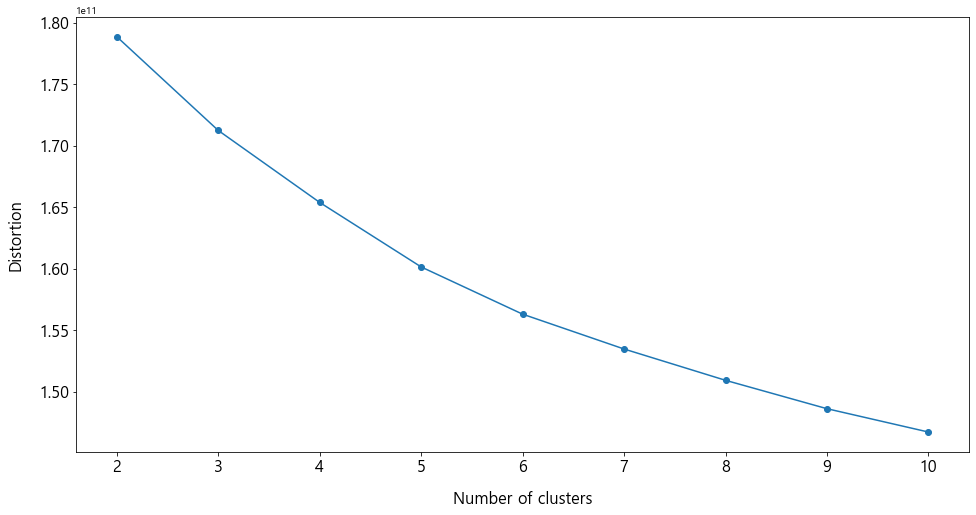

In [95]:
# 엘보 방법
distortions = []

for i in range(2,11):
    kmeans_i = KMeans(n_clusters = i, random_state = 0) # 모형 생성
    kmeans_i.fit(digits_2d) # 모형 훈련
    distortions.append(kmeans_i.inertia_)
    
plt.figure(figsize = (16, 8))
plt.plot(range(2,11), distortions, marker = 'o')
plt.xlabel("Number of clusters", size=16, labelpad=15)
plt.xticks(fontsize=16)
plt.ylabel("Distortion", size=16, labelpad=15)
plt.yticks(fontsize=16)
plt.show()

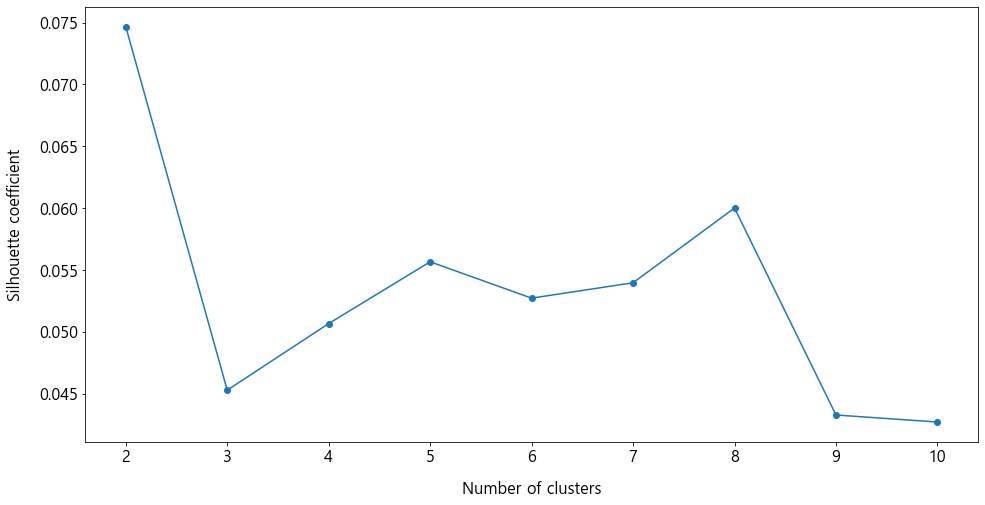

In [96]:
# 실루엣 계수
silhouette = []

for i in range(2,11):
    kmeans_i = KMeans(n_clusters = i, random_state = 0) # 모형 생성
    kmeans_i.fit(digits_2d) # 모형 훈련
    silhouette_values = silhouette_score(digits_2d, kmeans_i.labels_)
    silhouette.append(silhouette_values)

plt.figure(figsize = (16, 8))
plt.plot(range(2,11), silhouette, marker = 'o')
plt.xlabel("Number of clusters", size=16, labelpad=15)
plt.xticks(fontsize=16)
plt.ylabel("Silhouette coefficient", size=16, labelpad=15)
plt.yticks(fontsize=16)
plt.show()

**피크를 찍은 n값은 5, 컴퓨터는 픽셀 데이터를 통해 어떠한 숫자들을 비슷하다고 느끼는지**

실루엣 계수가 n값이 5일 때 유의미한 피크 값을 기록하지만, 숫자의 종류는 10가지이기 때문에 K-means를 통한 분석 방식은 숫자 인식에 한하여는 적절하지 못한 분석 성능을 보일 것으로 예상해볼 수 있다. 실제로 어떠한 결과가 나왔는지를 n값이 5일 때와 10일 때 각각 확인해보자.

In [166]:
# 각 label의 평균 이미지를 출력하는 함수 작성(label 별 출력은 숫자 구성 비율 시각화로 대체)
def draw_digits(arr, ratio = 1):
    n = len(arr)
    rows = int(np.ceil(n/10))
    cols = n if rows < 2 else 10
    fig, axes = plt.subplots(rows, cols, figsize = (cols*ratio*2, rows*ratio*2), squeeze = False)
    
    for i in range(rows):
        for j in range(cols):
            if i*10 +j < n:
                axes[i, j].imshow(arr[i*10 + j], cmap = "gray")
            axes[i, j].axis("off")
    plt.show()

In [172]:
# 각 label에서 실제 숫자들이 어떻게 분포되어있는지 출력하는 함수 작성
def draw_pie(values, labels):
    plt.figure(figsize=(10,10))
    plt.pie(x = values, labels = labels, pctdistance = 0.7,
            colors = ["#EA4235", "#FABC05", "#34A853", "#4286F5", "#8A8D92"],
            wedgeprops={"width": 0.5, "edgecolor": "#FFFFFF", "linewidth": 10},
            autopct="%.2f%%", startangle=45, textprops={"size": 25})
    
    plt.show()

### 이미지 클러스터링(n=5)

In [90]:
kmeans_5_digits = KMeans(n_clusters = 5, random_state = 0)
kmeans_5_digits.fit(digits_2d)
print(kmeans_5_digits.labels_)

[4 2 4 ... 3 0 3]


In [91]:
print(np.unique(kmeans_5_digits.labels_, return_counts = True))

(array([0, 1, 2, 3, 4]), array([ 7655,  8981,  3856, 11998,  9510], dtype=int64))


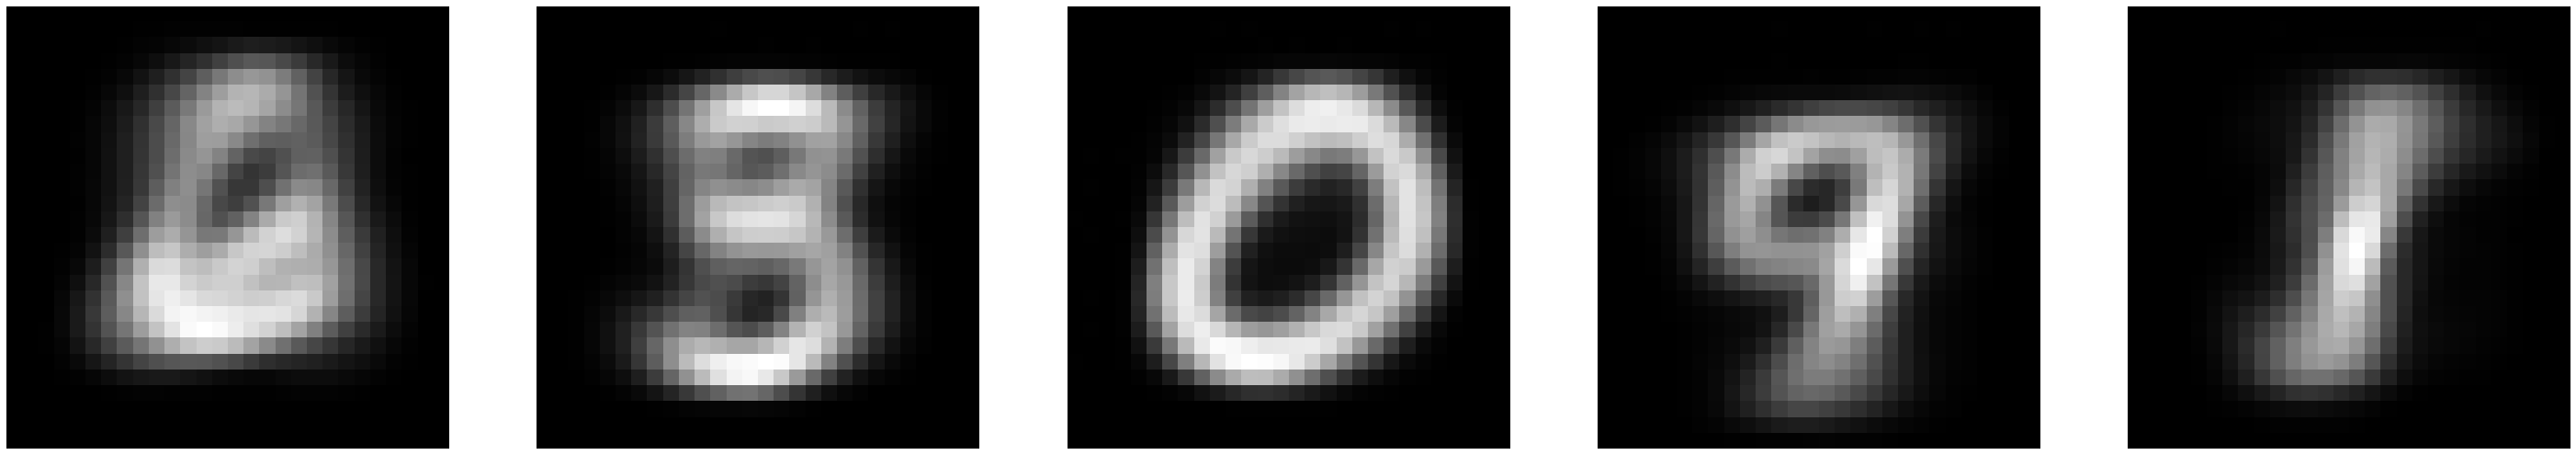

In [167]:
# 각 cluster의 중심을 이미지로 복구
draw_digits(kmeans_5_digits.cluster_centers_.reshape(-1, 28, 28), ratio = 5)

n값이 5일 때, 시각적으로 파악할 수 있는 부분은 숫자의 형태가 뚜렷하지 않는 경우라면 <u>컴퓨터는 이를 동일한 레이블로 인식</u>한다는 점이다. 출력 레이블 순서대로 마치 (0) '2, 4, 5, 6' / (1) '3, 8' / (2) '0' / (3) '9' / (4) '1, 7'의 다섯가지 레이블로 구분이 된 것처럼 보인다. 각 레이블별로 실제 어떠한 숫자들이 분포가 되어있는지를 알아보자. 이 때, 비지도학습으로 분류된 결과를 출력 순서대로 각각 레이블 0~4로 표현하고, 해당 레이블에 속해있는 데이터를 레이블이 아닌 숫자라고 표현한다.

### 레이블별 구성 요소(n=5)

In [110]:
# digits과 train.csv 데이터셋는 인덱스 순서가 동일
nums = np.array(df["label"])

In [245]:
# label 0
n5_label0_length = (kmeans_5_digits.labels_ == 0).sum()
n5_label0_counter = Counter(nums[kmeans_5_digits.labels_ == 0])

# 내림차순 정렬 + 상위 4개
n5_label0_counter = {num : count for num, count in n5_label0_counter.most_common(4)} 

# 제외된 숫자들을 other로 묶어서 key-value 쌍으로 추가
n5_label0_counter["other"] = n5_label0_length - sum(n5_label0_counter.values())

display(n5_label0_counter)

{6: 3573, 2: 2801, 4: 379, 0: 278, 'other': 624}

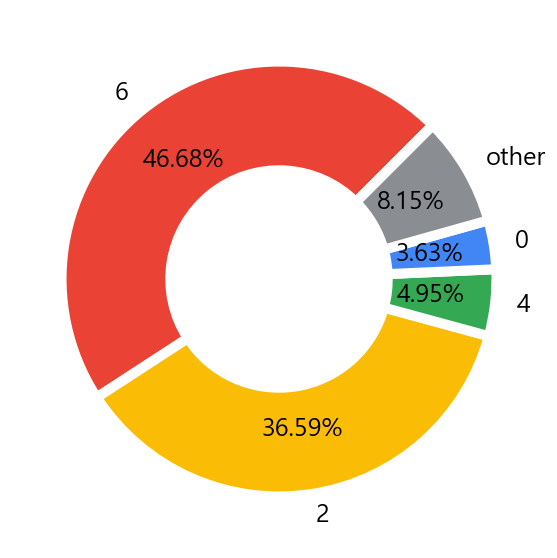

In [246]:
draw_pie(n5_label0_counter.values(), n5_label0_counter.keys())

In [247]:
# label 1
n5_label1_length = (kmeans_5_digits.labels_ == 1).sum()
n5_label1_counter = Counter(nums[kmeans_5_digits.labels_ == 1])

# 내림차순 정렬 + 상위 4개
n5_label1_counter = {num : count for num, count in n5_label1_counter.most_common(4)} 

# 제외된 숫자들을 other로 묶어서 key-value 쌍으로 추가
n5_label1_counter["other"] = n5_label1_length - sum(n5_label1_counter.values())

display(n5_label1_counter)

{3: 3601, 8: 2247, 5: 2045, 2: 607, 'other': 481}

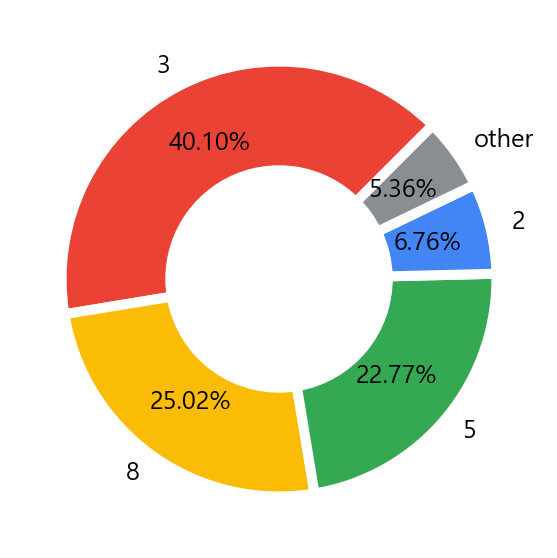

In [248]:
draw_pie(n5_label1_counter.values(), n5_label1_counter.keys())

In [249]:
# label 2
n5_label2_length = (kmeans_5_digits.labels_ == 2).sum()
n5_label2_counter = Counter(nums[kmeans_5_digits.labels_ == 2])

# 내림차순 정렬 + 상위 4개
n5_label2_counter = {num : count for num, count in n5_label2_counter.most_common(4)} 

# 제외된 숫자들을 other로 묶어서 key-value 쌍으로 추가
n5_label2_counter["other"] = n5_label2_length - sum(n5_label2_counter.values())

display(n5_label2_counter)

{0: 3512, 6: 78, 2: 66, 5: 60, 'other': 140}

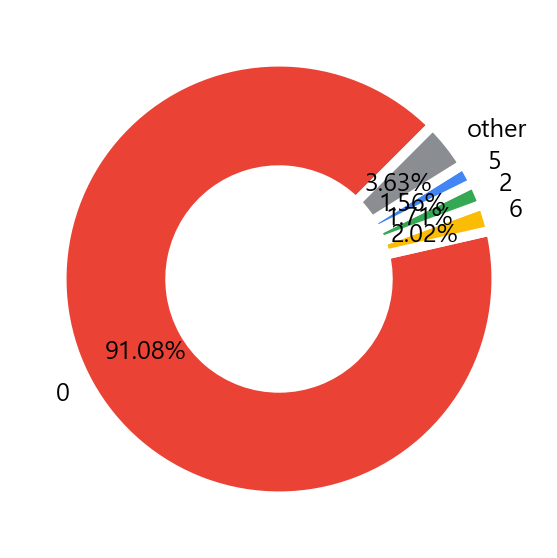

In [250]:
draw_pie(n5_label2_counter.values(), n5_label2_counter.keys())

In [251]:
# label 3
n5_label3_length = (kmeans_5_digits.labels_ == 3).sum()
n5_label3_counter = Counter(nums[kmeans_5_digits.labels_ == 3])

# 내림차순 정렬 + 상위 4개
n5_label3_counter = {num : count for num, count in n5_label3_counter.most_common(4)} 

# 제외된 숫자들을 other로 묶어서 key-value 쌍으로 추가
n5_label3_counter["other"] = n5_label3_length - sum(n5_label3_counter.values())

display(n5_label3_counter)

{7: 3757, 9: 3585, 4: 3344, 5: 521, 'other': 791}

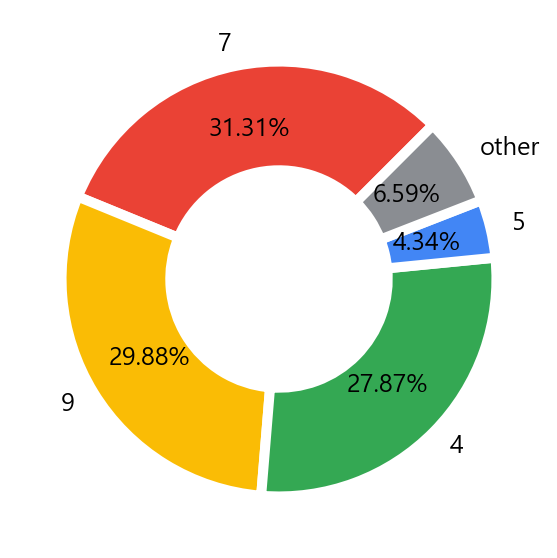

In [252]:
draw_pie(n5_label3_counter.values(), n5_label3_counter.keys())

In [253]:
# label 4
n5_label4_length = (kmeans_5_digits.labels_ == 4).sum()
n5_label4_counter = Counter(nums[kmeans_5_digits.labels_ == 4])

# 내림차순 정렬 + 상위 4개
n5_label4_counter = {num : count for num, count in n5_label4_counter.most_common(4)} 

# 제외된 숫자들을 other로 묶어서 key-value 쌍으로 추가
n5_label4_counter["other"] = n5_label4_length - sum(n5_label4_counter.values())

display(n5_label4_counter)

{1: 4647, 8: 1141, 5: 1011, 7: 585, 'other': 2126}

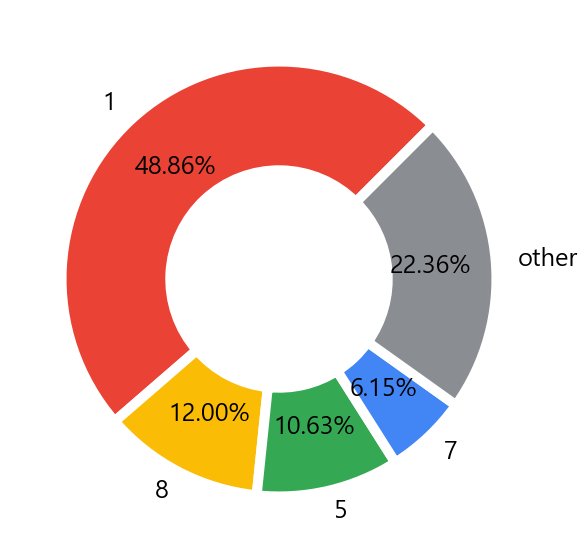

In [254]:
draw_pie(n5_label4_counter.values(), n5_label4_counter.keys())

0과 같이 하나의 숫자가 압도적인 비율로 레이블을 구성한 경우도 있던 반면, 대부분의 레이블은 적게는 2개에서 많게는 3개의 숫자가 혼합되어 구성이 되어 있었다. 즉, 컴퓨터는 레이블 (2)를 0이라는 하나의 단일한 숫자로 특정을 지었고 레이블 (4)를 대체로 1로 특정을 지었지만, 각 레이블 별로 (0) 6, 2 / (1) 3, 5 / (3) 7, 9, 5 의 숫자는 유사한 형태로 학습한 것이다.

### 이미지 클러스터링(n=10)
인위적으로 n의 값을 숫자의 개수와 동일하게 10으로 설정하였을 때의 분석 결과를 알아보자.

In [188]:
kmeans_10_digits = KMeans(n_clusters = 10, random_state = 0)
kmeans_10_digits.fit(digits_2d)
print(kmeans_10_digits.labels_)

[1 3 9 ... 4 0 4]


In [189]:
print(np.unique(kmeans_10_digits.labels_, return_counts = True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([3810, 3646, 3826, 3538, 4967, 4722, 5471, 5026, 3263, 3731],
      dtype=int64))


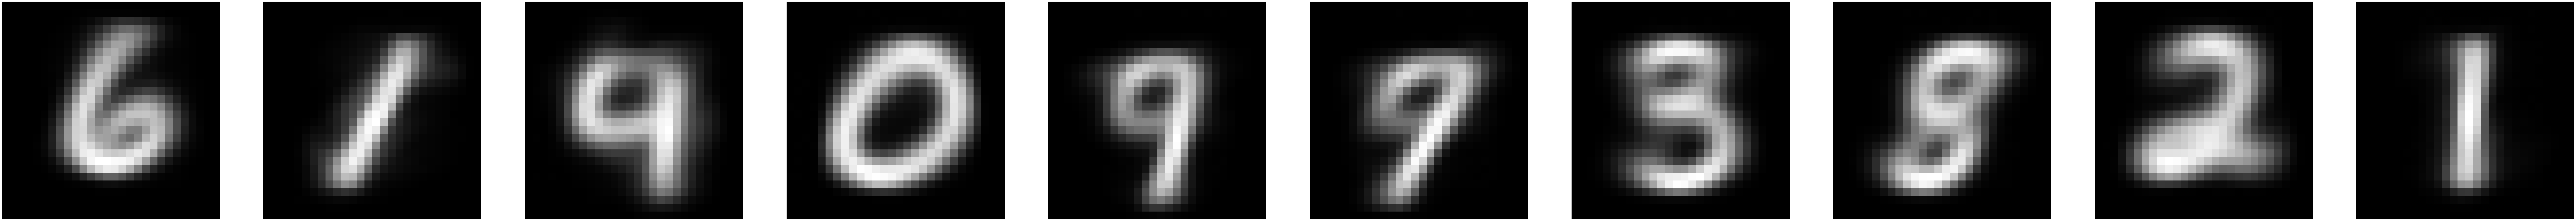

In [190]:
# 각 cluster의 중심을 이미지로 복구
draw_digits(kmeans_10_digits.cluster_centers_.reshape(-1, 28, 28), ratio = 10)

### 레이블별 구성 요소(n=10)

In [255]:
# label 0
n10_label0_length = (kmeans_10_digits.labels_ == 0).sum()
n10_label0_counter = Counter(nums[kmeans_10_digits.labels_ == 0])

# 내림차순 정렬 + 상위 4개
n10_label0_counter = {num : count for num, count in n10_label0_counter.most_common(4)} 

# 제외된 숫자들을 other로 묶어서 key-value 쌍으로 추가
n10_label0_counter["other"] = n10_label0_length - sum(n10_label0_counter.values())

display(n10_label0_counter)

{6: 3236, 0: 162, 2: 119, 4: 95, 'other': 198}

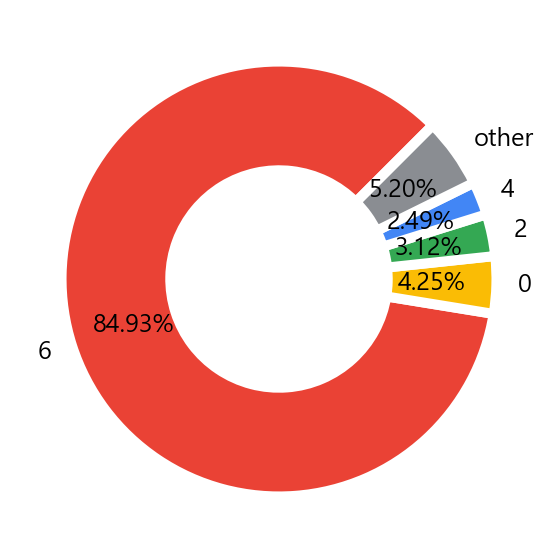

In [256]:
draw_pie(n10_label0_counter.values(), n10_label0_counter.keys())

In [257]:
# label 1
n10_label1_length = (kmeans_10_digits.labels_ == 1).sum()
n10_label1_counter = Counter(nums[kmeans_10_digits.labels_ == 1])

# 내림차순 정렬 + 상위 4개
n10_label1_counter = {num : count for num, count in n10_label1_counter.most_common(4)} 

# 제외된 숫자들을 other로 묶어서 key-value 쌍으로 추가
n10_label1_counter["other"] = n10_label1_length - sum(n10_label1_counter.values())

display(n10_label1_counter)

{1: 2008, 5: 500, 2: 263, 8: 251, 'other': 624}

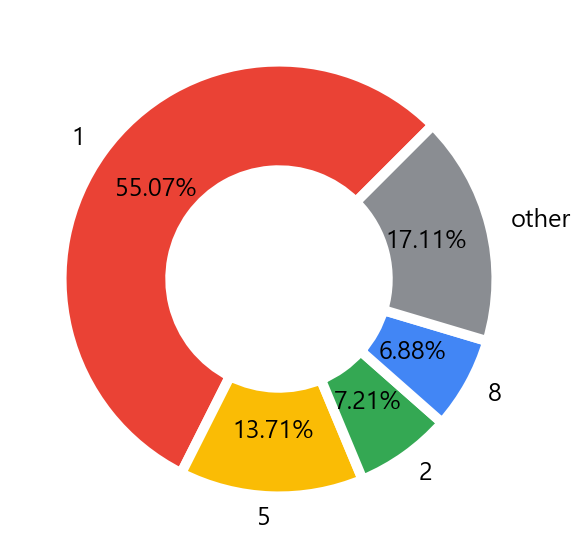

In [258]:
draw_pie(n10_label1_counter.values(), n10_label1_counter.keys())

In [263]:
# label 2
n10_label2_length = (kmeans_10_digits.labels_ == 2).sum()
n10_label2_counter = Counter(nums[kmeans_10_digits.labels_ == 2])

# 내림차순 정렬 + 상위 4개
n10_label2_counter = {num : count for num, count in n10_label2_counter.most_common(4)} 

# 제외된 숫자들을 other로 묶어서 key-value 쌍으로 추가
n10_label2_counter["other"] = n10_label2_length - sum(n10_label2_counter.values())

display(n10_label2_counter)

{4: 1563, 9: 1015, 7: 406, 6: 369, 'other': 473}

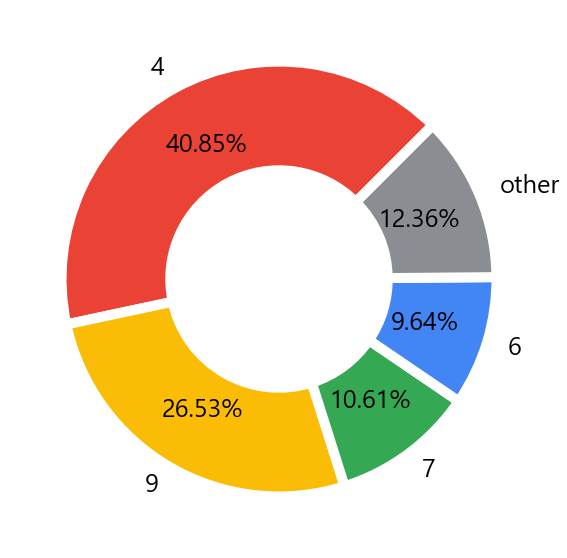

In [264]:
draw_pie(n10_label2_counter.values(), n10_label2_counter.keys())

In [261]:
# label 3
n10_label3_length = (kmeans_10_digits.labels_ == 3).sum()
n10_label3_counter = Counter(nums[kmeans_10_digits.labels_ == 3])

# 내림차순 정렬 + 상위 4개
n10_label3_counter = {num : count for num, count in n10_label3_counter.most_common(4)} 

# 제외된 숫자들을 other로 묶어서 key-value 쌍으로 추가
n10_label3_counter["other"] = n10_label3_length - sum(n10_label3_counter.values())

display(n10_label3_counter)

{0: 3310, 6: 69, 5: 43, 2: 36, 'other': 80}

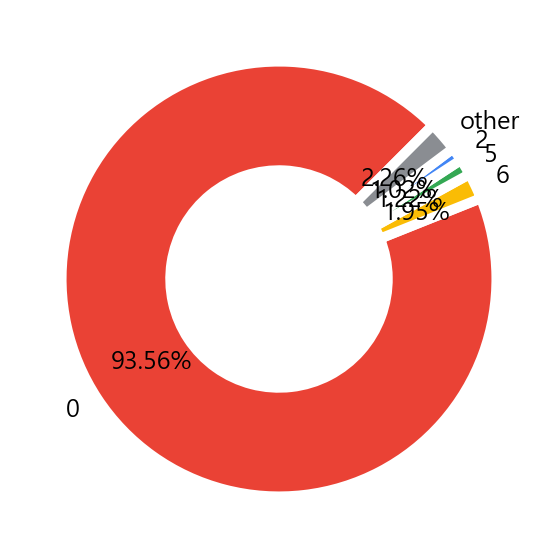

In [262]:
draw_pie(n10_label3_counter.values(), n10_label3_counter.keys())

In [373]:
# label 4
n10_label4_length = (kmeans_10_digits.labels_ == 4).sum()
n10_label4_counter = Counter(nums[kmeans_10_digits.labels_ == 4])

# 내림차순 정렬 + 상위 4개
n10_label4_counter = {num : count for num, count in n10_label4_counter.most_common(4)} 

# 제외된 숫자들을 other로 묶어서 key-value 쌍으로 추가
n10_label4_counter["other"] = n10_label4_length - sum(n10_label4_counter.values())

display(n10_label4_counter)

{9: 1713, 7: 1669, 4: 1084, 5: 190, 'other': 311}

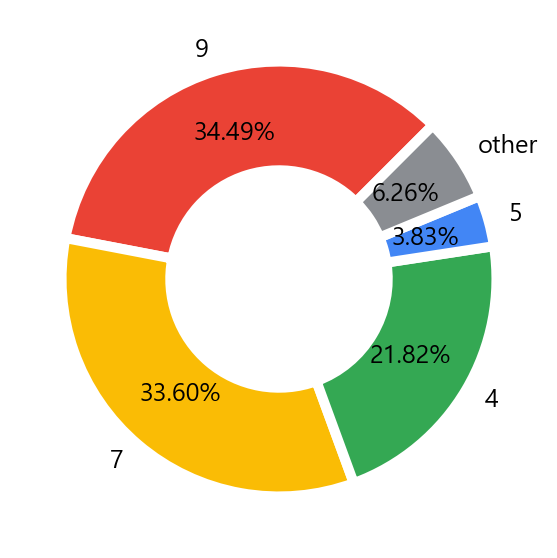

In [374]:
draw_pie(n10_label4_counter.values(), n10_label4_counter.keys())

In [375]:
# label 5
n10_label5_length = (kmeans_10_digits.labels_ == 5).sum()
n10_label5_counter = Counter(nums[kmeans_10_digits.labels_ == 5])

# 내림차순 정렬 + 상위 4개
n10_label5_counter = {num : count for num, count in n10_label5_counter.most_common(4)} 

# 제외된 숫자들을 other로 묶어서 key-value 쌍으로 추가
n10_label5_counter["other"] = n10_label5_length - sum(n10_label5_counter.values())

display(n10_label5_counter)

{7: 1970, 9: 1190, 4: 1082, 5: 220, 'other': 260}

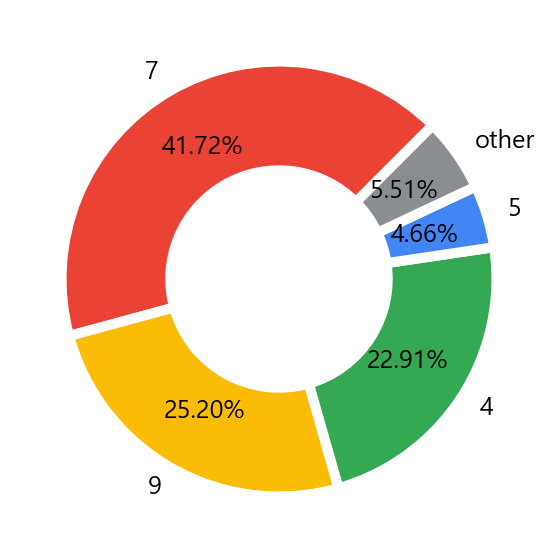

In [376]:
draw_pie(n10_label5_counter.values(), n10_label5_counter.keys())

In [377]:
# label 6
n10_label6_length = (kmeans_10_digits.labels_ == 6).sum()
n10_label6_counter = Counter(nums[kmeans_10_digits.labels_ == 6])

# 내림차순 정렬 + 상위 4개
n10_label6_counter = {num : count for num, count in n10_label6_counter.most_common(4)} 

# 제외된 숫자들을 other로 묶어서 key-value 쌍으로 추가
n10_label6_counter["other"] = n10_label6_length - sum(n10_label6_counter.values())

display(n10_label6_counter)

{3: 2706, 5: 1264, 8: 968, 2: 278, 'other': 255}

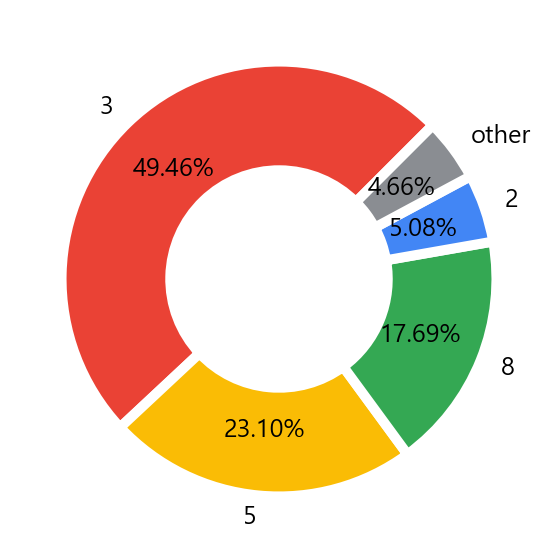

In [378]:
draw_pie(n10_label6_counter.values(), n10_label6_counter.keys())

In [379]:
# label 7
n10_label7_length = (kmeans_10_digits.labels_ == 7).sum()
n10_label7_counter = Counter(nums[kmeans_10_digits.labels_ == 7])

# 내림차순 정렬 + 상위 4개
n10_label7_counter = {num : count for num, count in n10_label7_counter.most_common(4)} 

# 제외된 숫자들을 other로 묶어서 key-value 쌍으로 추가
n10_label7_counter["other"] = n10_label7_length - sum(n10_label7_counter.values())

display(n10_label7_counter)

{8: 2207, 5: 1284, 3: 932, 0: 372, 'other': 231}

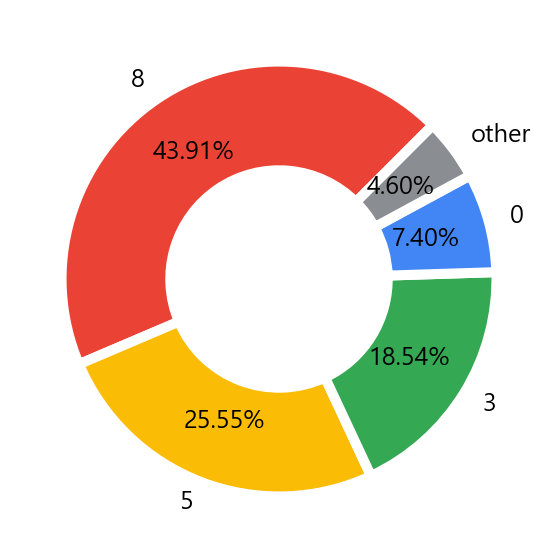

In [380]:
draw_pie(n10_label7_counter.values(), n10_label7_counter.keys())

In [381]:
# label 8
n10_label8_length = (kmeans_10_digits.labels_ == 8).sum()
n10_label8_counter = Counter(nums[kmeans_10_digits.labels_ == 8])

# 내림차순 정렬 + 상위 4개
n10_label8_counter = {num : count for num, count in n10_label8_counter.most_common(4)} 

# 제외된 숫자들을 other로 묶어서 key-value 쌍으로 추가
n10_label8_counter["other"] = n10_label8_length - sum(n10_label8_counter.values())

display(n10_label8_counter)

{2: 2940, 3: 163, 6: 46, 8: 35, 'other': 79}

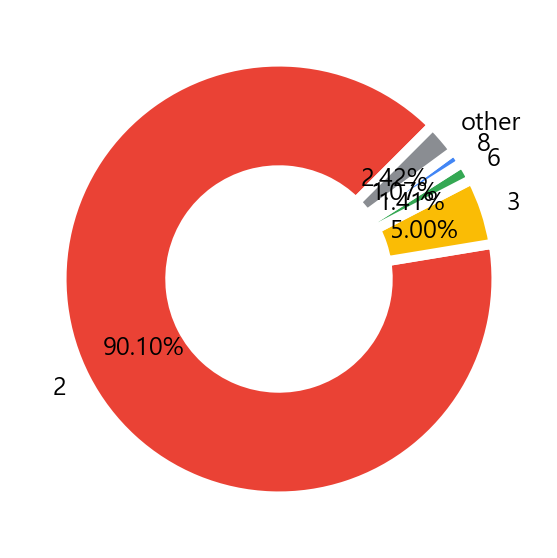

In [382]:
draw_pie(n10_label8_counter.values(), n10_label8_counter.keys())

In [383]:
# label 9
n10_label9_length = (kmeans_10_digits.labels_ == 9).sum()
n10_label9_counter = Counter(nums[kmeans_10_digits.labels_ == 9])

# 내림차순 정렬 + 상위 4개
n10_label9_counter = {num : count for num, count in n10_label9_counter.most_common(4)} 

# 제외된 숫자들을 other로 묶어서 key-value 쌍으로 추가
n10_label9_counter["other"] = n10_label9_length - sum(n10_label9_counter.values())

display(n10_label9_counter)

{1: 2641, 3: 232, 2: 208, 6: 154, 'other': 496}

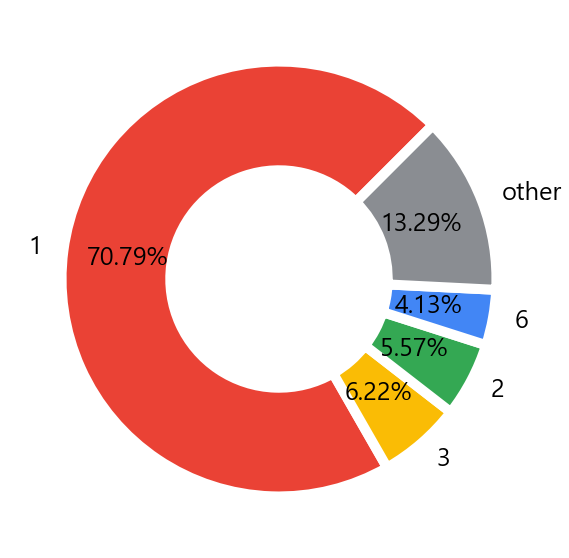

In [384]:
draw_pie(n10_label9_counter.values(), n10_label9_counter.keys())

클러스터 개수를 인위적으로 10개로 증가시키고 분석을 하였음에도 잘못 인식을 한 경우가 많은 것을 확인할 수 있다. 숫자 0, 1, 2, 6을 제외한 숫자들은 각각의 레이블에 규칙없이 섞여있는 모습을 확인할 수 있다. 필체와 펜의 종류에 영향을 적게 받으면서 확실한 인식이 가능한 기법 중 실제 이미지의 문자나 숫자를 인식할 때 높은 인식 성능을 것에는 무엇이 있을까?

---
# 4. 결론 및 한계점

&nbsp;단순한 평균 픽셀값으로 분류를 진행한 평균 이미지 방식에서는 평균 이미지 방식 숫자 인식 원리를 기계학습 방법론을 통해 알아보았을 때 먼저 지도 학습 방식(KNN)에서는 테스트 데이터셋에 대해 꽤나 정확한 분류를 해냈지만 필체와 펜의 굵기 등의 조건이 달라지면 새로운 이미지에 대해서는 제대로 인식을 못하는 한계를 보여줬다. 그리고 비지도 학습 방식(K-means)에서는 추론을 통한 최적의 클러스터 개수인 5와 임의로 설정한 클러스터 개수인 10 모두 기대했던 클러스터링을 수행하지 못하였고, 이에 대한 원인으로는 사람이 인식하는 숫자 형태의 특징과 컴퓨터가 학습하는 숫자 형태의 특징이 서로 다르고 다른 형태의 숫자도 하나의 특징으로 인식하기 때문으로 보인다.

&nbsp;정리하자면, 평균 이미지 방식에서는 평균 이미지와 인식할 이미지의 위치별 픽셀값 계산을 통해 결과를 계산하였기 때문에 전체적인 정확도가 낮다는 단점이 있었다. 또한 지도학습 방식에서는 정제된 이미지를 통한 학습을 진행하였기 때문에 학습에 진행한 데이터셋에 한정된 정확도는 높더라도 새로운 형태의 숫자에는 높은 인식을 보여주지 못한다는 한계점이 존재한다. 마지막으로, 비지도학습 방식에서는 1차원으로된 이미지 정보의 숫자별 특징을 온전히 컴퓨터가 학습하게 하였기 때문에 사람이 인식하는 숫자의 특징과는 괴리감이 존재하는 형태로 분류를 하였다는 한계점이 존재한다.

&nbsp;실제 사용되는 문자 혹은 숫자 인식 기법에서는, 위와 같은 한계점이 개선된 CNN이라는 딥러닝 신경망 아키텍처를 사용한다. 이에 대한 특징은 아래와 같다.

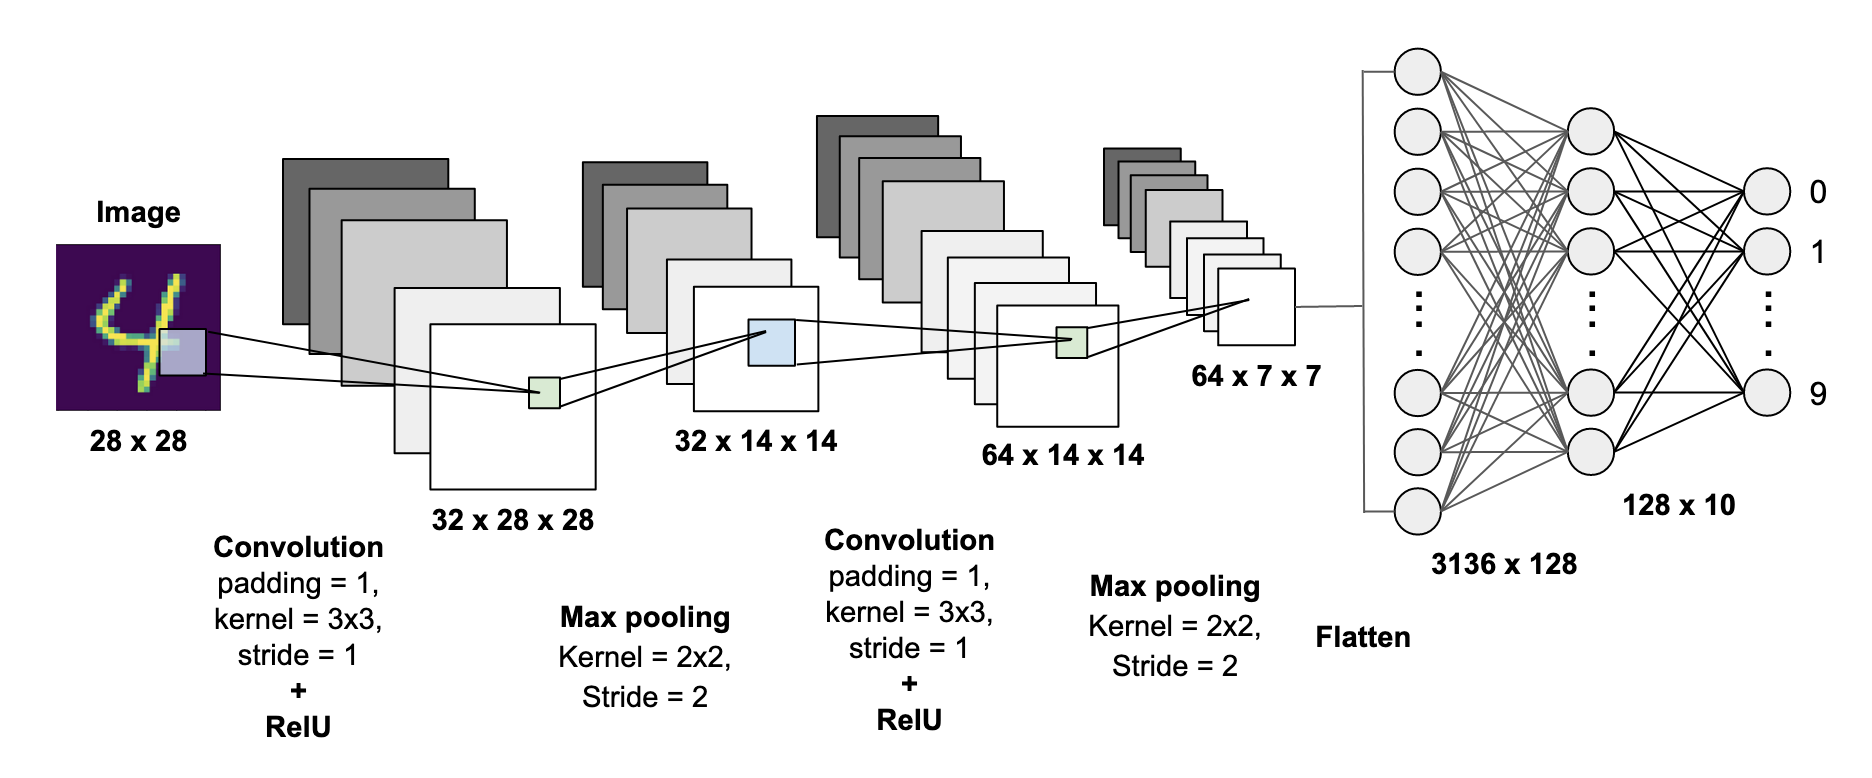

In [364]:
Image("cnn.png")

- DNN(Deep Neural Network)에서 이미지나 영상 데이터 처리에 더욱 특화되는 방향으로 보완한 딥러닝 기법인 CNN(Convolutional Neural Networks)은 인간의 시신경 구조를 모방하여 데이터를 직접 학습하고 특징을 추출할 필요 없이 데이터 자체의 이미지 패턴을 활용해 이미지와 영상을 분류하는 딥러닝 신경망 아키텍처이다.
- 이름에서도 알 수 있듯, Convolution이라는 전처리 작업이 들어가는데, 하나의 이미지를 행렬로 나타냈을 때 해당 데이터의 패턴을 찾기 위해 이미지의 일부 영역을 임의의 크기의 필터를 적용하여 이미지의 인접한 영역의 특징을 효과적으로 인식할 수 있다.
- 이렇게 이미지의 패턴을 학습하기 때문에 이미지의 원본 자체와 공간정보를 유지할 수 있다는 것이 CNN 기법의 핵심이다.
- 위에서 진행한 세 가지 방식 중 평균 이미지 방식은 이미지의 위치별 픽셀 값을 활용하긴 하였지만, 단순히 분석하는 이미지와 픽셀 위치별로 1:1로 연산을 진행하였고, 기계학습 방식(지도/비지도)은 모두 이미지 데이터를 1차원 행렬로 변환을 하여 분석에 활용을 하였다는 점에서 큰 차이점을 보인다.
- 즉, 이미지의 차원을 유지하여 학습을 진행한다는 점에서, 인간이 이미지를 인식하는 것과 유사한 방식이라고도 표현할 수 있는 것이다.